# Hand Writing Recognition - EMNIST

# 1. Load Dataset

Hal yang pertama kita lakukan adalah kita melakukan mendownload sebuah dataset dimana kita menggunakan [EMNIST (Extended MNIST)](https://www.kaggle.com/datasets/crawford/emnist) & [Math Symbols](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols)

# 2. Load Libraries

Memuat semua library yang diperlukan untuk analisis data, visualisasi, dan pembangunan model deep learning

In [2]:
import math
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, LeakyReLU, AvgPool2D, BatchNormalization, Reshape
)
from keras.utils import Sequence, to_categorical
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback,
    LearningRateScheduler
)
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils import class_weight

from tqdm import tqdm
import nltk

print(tf.__version__)

2.19.0


# 3. Data Preprocessing

Preprocessing data sangat penting sebelum membangun model deep learning.

### About the dataset
Dataset EMNIST terdiri dari karakter tulisan tangan (A-Z, a-z, 0-9) yang telah dikonversi ke format gambar 28x28 piksel.


**Kami memiliki 697932 baris masing-masing masing masing dijelaskan menggunakan 785 variabel berukuran 28*28**

In [3]:
## Reading using pandas

train_df = pd.read_csv(r'C:\Users\LENOVO\tubesAILab\emnist\emnist-byclass-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(697932, 785)

In [5]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,697932.000000,697932.0,697932.0,697932.0,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,...,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.0,697932.0,697932.0,697932.0,697932.0
mean,19.381620,0.0,0.0,0.0,0.000009,0.000878,0.004574,0.007309,0.007537,0.007203,...,0.000050,0.000047,0.000047,0.000350,0.000046,0.0,0.0,0.0,0.0,0.0
std,17.849636,0.0,0.0,0.0,0.006104,0.242795,0.789262,1.022129,1.055924,1.053376,...,0.041895,0.039501,0.039501,0.292068,0.038304,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,4.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,10.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,32.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,61.000000,0.0,0.0,0.0,5.000000,107.000000,215.000000,217.000000,247.000000,217.000000,...,35.000000,33.000000,33.000000,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


## 3.1 Membuat kamus label (klasifikasikan berdasarkan label)

Variabel output terdiri dari 62 nilai, diantaranya 0-9 mewakili angka 0-9, 10-35 mewakili A-Z, dan 36-62 mewakili a-z, oleh karena itu kami mengelompokan yang akan memiliki nilai-nilai ini sebagai pasangan kunci dan nilai

Dalam dataset EMNIST kita terdapat file emnist-balanced-mapping.csv yang berisi karakter dan padanan ASCII-nya. Nah kita bisa memanfaatkan sebagai kunci kamus dan nilai kode ASCII yang dikonversi ke char sebagai nilai kamus

In [6]:
label_map = pd.read_csv(r'C:\Users\LENOVO\tubesAILab\emnist\emnist-byclass-mapping.txt', 
                        delimiter=' ', 
                        index_col=0, 
                        header=None)

In [7]:
label_map.head()

,1
0,
0,48
1,49
2,50
3,51
4,52


In [8]:
label_dictionary = {}

for index, label in enumerate(label_map[1]):  # Accessing the second column which contains ASCII codes
    label_dictionary[index] = chr(label)

In [9]:
label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'c',
 39: 'd',
 40: 'e',
 41: 'f',
 42: 'g',
 43: 'h',
 44: 'i',
 45: 'j',
 46: 'k',
 47: 'l',
 48: 'm',
 49: 'n',
 50: 'o',
 51: 'p',
 52: 'q',
 53: 'r',
 54: 's',
 55: 't',
 56: 'u',
 57: 'v',
 58: 'w',
 59: 'x',
 60: 'y',
 61: 'z'}

**Kita akan menggunakan SEMUA 62 kelas dari dataset EMNIST ByClass.:**
- **0-9**: Numerik (10 classes)
- **10-35**: Huruf Kapital A-Z (26 classes)
- **36-61**: Huruf Kecil a-z (26 classes)

Ini memberikan kita total **62 classes** untuk pengenalan tulisan tangan

## 3.2 Prepare Data

Kita akan menggunakan dataset lengkap dengan semua 62 kelas (angka, huruf besar, dan huruf kecil).

In [10]:
train_df_new = train_df.copy()
train_df_new

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697927,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697928,47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697929,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697930,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_df_new[0].describe()

count    697932.000000
mean         19.381620
std          17.849636
min           0.000000
25%           4.000000
50%          10.000000
75%          32.000000
max          61.000000
Name: 0, dtype: float64

In [12]:
train_df_new.reset_index(inplace=True)
train_df_new

,index,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697927,697927,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697928,697928,47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697929,697929,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697930,697930,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Selanjutnya, kita akan memisahkan variabel output (y) dari variabel input (x)**


Sekarang, kita pisahkan variabel input (x_train) dan output (y_train) dan periksa bentuk variabel input dan output:

In [13]:
x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]

x_train.shape, y_train.shape

((697932, 784), (697932,))

## 3.3 Visualizing Data

In [14]:
sample_image = x_train.iloc[1000]
sample_label = y_train.iloc[1000]
sample_image.shape, sample_label

((784,), np.int64(9))

Label entry No. 1000: 9


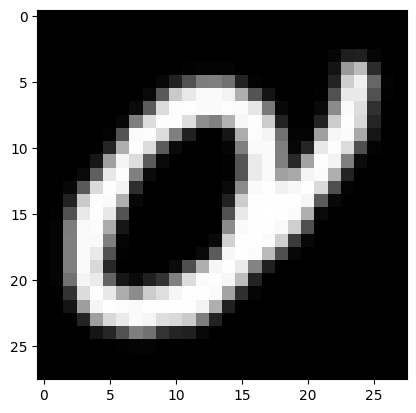

In [15]:
W = 28
H = 28

print("Label entry No. 1000:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

***Kita bisa melihat bahwa gambarnya terputar 90 derajat berlawanan arah jarum jam dan juga terbalik. Oleh karena itu, kita akan mendefinisikan sebuah fungsi untuk memutar dan membalikkan gambar, lalu melihat apakah fungsi tersebut berhasil pada gambar sampel.**

Label entry 1000: 9


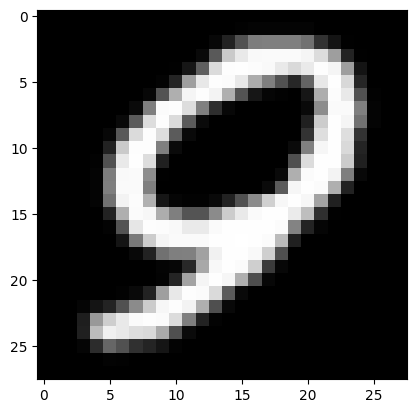

In [16]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 1000:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

**Sekarang kita ingin menerapkan reshape_and_rotate (fungsi putar & balik) ke semua gambar di X_train**

In [17]:
x_train = np.apply_along_axis(flip_and_rotate, 1, x_train.values)
x_train.shape

(697932, 28, 28)

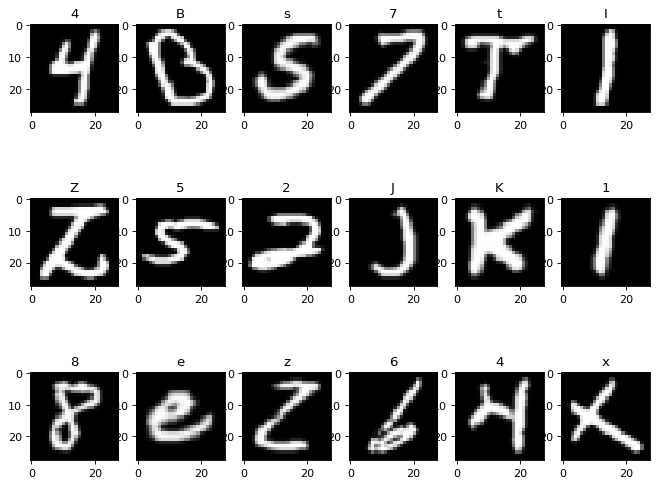

In [18]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3,6,i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

## 3.4 Normalizing the Data

Kita menskalakan nilai input agar berada dalam rentang 0 hingga 1 untuk kinerja yang lebih baik dalam pelatihan jaringan saraf (neural network).

In [19]:
#Data Scaling to bring the input values between 0 to 1
x_train = x_train.astype('float32') / 255
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00784314, 0.00784314,
        0.00784314, 0.01568628, 0.01568628, 0.01568628, 0.01568628,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00392157, 0.13333334, 0.32941177, 0.6666667 , 0.6784314 ,
        0.68235296, 0.8509804 , 0.8509804 , 0.8509804 , 0.79607844,
        0.5058824 , 0.4470

## 3.5 One Hot Encoding of the Output Labels

Karena nilai output berupa bilangan bulat (integer), kita melakukan one-hot encoding untuk mengubahnya menjadi format yang sesuai untuk klasifikasi. Ini menghasilkan beberapa kolom output dengan label kelas biner (0 dan 1).

In [20]:
#Finding the number of output columns
number_of_classes = y_train.nunique()
number_of_classes

62

**Kita menggunakan to_categorical() dari Keras untuk mengubah label menjadi format one-hot encoded..**

In [21]:
#One hot encoding of numpy array
y_train = to_categorical(y_train, number_of_classes)
y_train.shape

(697932, 62)

## 3.6 Reshaping the train data

Karena TensorFlow memerlukan array 4D dalam format: (batch_size, lebar, tinggi, channel), tetapi x_train kita saat ini adalah array 3D: (jumlah_gambar, lebar, tinggi), maka kita perlu menambahkan dimensi tambahan untuk channel (gambar grayscale memiliki 1 channel).

In [22]:
x_train.shape

(697932, 28, 28)

In [23]:
x_train = x_train.reshape(-1, W, H, 1)
x_train.shape

(697932, 28, 28, 1)

## 3.7 Train and Validation Split

Untuk mengevaluasi model secara efektif, kita membagi dataset menjadi set pelatihan (90%) dan validasi (10%). Set validasi membantu menilai kinerja model pada data yang belum pernah dilihat sebelumnya, sebelum dilakukan pengujian.

In [24]:
# Split 10% validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size= 0.1, 
                                                  random_state=88)

# 4. Model Building

Kita akan membangun CNN (Convolutional Neural Network) menggunakan Sequential dari Keras. Model ini terdiri dari:

- Tiga blok konvolusi bertingkat (32→64→128 filter) dengan aktivasi ReLU.
- Batch Normalization setelah setiap layer konvolusi untuk mempercepat dan menstabilkan proses training.
- Tiga layer max pooling (MaxPool2D) dengan stride=2 untuk mengurangi dimensi feature maps secara progresif.
- Dropout regularization dengan nilai berbeda (25%, 25%, 40%) di setiap blok konvolusi untuk mencegah overfitting.
- Satu lapisan perataan (Flatten) untuk mengubah feature maps 3D menjadi vektor 1D.
- Lapisan fully connected (Dense) dengan 256 neuron, diikuti BatchNorm dan Dropout 50%.
- Lapisan output terakhir dengan aktivasi softmax untuk klasifikasi multi-kelas (sesuai number_of_classes).

**Model ini menggunakan arsitektur yang lebih dalam dan teknik regularisasi modern dibandingkan deskripsi sebelumnya, dengan total 3 blok konvolusi (bukan 2) dan komponen tambahan untuk meningkatkan performa**

In [31]:
model = Sequential()

# Block 1 - Simplified
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Dropout(0.25))

# Block 2 - Simplified
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Dropout(0.25))

# Block 3 - Simplified
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Dropout(0.4))

# Dense layers - Simplified
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 62)                  │          15,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,694 (1.55 MB)

 Trainable params: 404,734 (1.54 MB)

 Non-trainable params: 960 (3.75 KB)

In [32]:
# ============================================================================
# COMPILE MODEL
# ============================================================================

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print("✅ Model compiled!")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Loss: categorical_crossentropy")
print(f"   Total parameters: {model.count_params():,}")

✅ Model compiled!
   Optimizer: Adam (lr=0.001)
   Loss: categorical_crossentropy
   Total parameters: 405,694


## 4.1 Fitting the model


Hyperparameters

- Batch size: 64
- Epochs: 10

In [33]:
batch_size = 128
epochs = 10



In [34]:
# ============================================================================
# DEFINE SEMUA CALLBACKS
# ============================================================================

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# 1. Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 2. Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    else:
        return lr * 0.1

lr_callback = LearningRateScheduler(scheduler, verbose=1)

# 3. Model Checkpoint (BONUS - save best model)
checkpoint = ModelCheckpoint(
    'best_writing_recognition_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("✅ Callbacks siap!")

✅ Callbacks siap!


In [35]:
# ============================================================================
# CALLBACKS - PREVENT OVERFIT & SAVE BEST MODEL
# ============================================================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Early Stopping - Stop kalau mulai overfit
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,              # ✅ Stop after 3 epochs without improvement
    verbose=1,
    mode='min',
    restore_best_weights=True  # ✅ Restore ke model terbaik
)

# 2. Reduce Learning Rate - Turunkan LR kalau stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # ✅ Turunkan LR jadi 50%
    patience=2,
    verbose=1,
    min_lr=1e-7
)

# 3. Model Checkpoint - Save best model
checkpoint = ModelCheckpoint(
    'best_writing_recognition_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("✅ Callbacks configured:")
print("   - Early Stopping (patience=3)")
print("   - Reduce LR on Plateau")
print("   - Model Checkpoint")

✅ Callbacks configured:
   - Early Stopping (patience=3)
   - Reduce LR on Plateau
   - Model Checkpoint


In [36]:
# ============================================================================
# DATA AUGMENTATION - LIGHT (untuk speed)
# ============================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Light augmentation - balance speed vs generalization
datagen = ImageDataGenerator(
    rotation_range=8,        # ✅ Reduced from 15
    width_shift_range=0.08,  # ✅ Reduced from 0.15
    height_shift_range=0.08, # ✅ Reduced from 0.15
    zoom_range=0.08          # ✅ Reduced from 0.15
    # Removed shear (slow!)
)

# ============================================================================
# TRAINING
# ============================================================================


history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("\n✅ Training completed!")
print(f"   Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"   Best model saved to: best_writing_recognition_model.h5")

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6918 - loss: 1.0829
Epoch 1: val_accuracy improved from -inf to 0.85231, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 703s 142ms/step - accuracy: 0.6918 - loss: 1.0829 - val_accuracy: 0.8523 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 2/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8186 - loss: 0.5260
Epoch 2: val_accuracy improved from 0.85231 to 0.85972, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 705s 144ms/step - accuracy: 0.8186 - loss: 0.5260 - val_accuracy: 0.8597 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 3/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8308 - loss: 0.4846
Epoch 3: val_accuracy improved from 0.85972 to 0.86264, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 697s 142ms/step - accuracy: 0.8308 - loss: 0.4846 - val_accuracy: 0.8626 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 4/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8345 - loss: 0.4693
Epoch 4: val_accuracy did not improve from 0.86264
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 678s 138ms/step - accuracy: 0.8345 - loss: 0.4693 - val_accuracy: 0.8611 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 5/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8373 - loss: 0.4576
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.86264
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 700s 143ms/step - accuracy: 0.8373 - loss: 0.4576 - val_accuracy: 0.8621 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 6/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8433 - loss: 0.4372
Epoch 6: val_accuracy improved from 0.86264 to 0.86310, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 711s 145ms/step - accuracy: 0.8433 - loss: 0.4372 - val_accuracy: 0.8631 - val_loss: 0.3674 - learning_rate: 5.0000e-04
Epoch 7/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8456 - loss: 0.4320
Epoch 7: val_accuracy improved from 0.86310 to 0.86526, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 1011s 206ms/step - accuracy: 0.8456 - loss: 0.4320 - val_accuracy: 0.8653 - val_loss: 0.3637 - learning_rate: 5.0000e-04
Epoch 8/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8476 - loss: 0.4249
Epoch 8: val_accuracy improved from 0.86526 to 0.86543, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 1055s 215ms/step - accuracy: 0.8476 - loss: 0.4249 - val_accuracy: 0.8654 - val_loss: 0.3628 - learning_rate: 5.0000e-04
Epoch 9/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8484 - loss: 0.4231
Epoch 9: val_accuracy did not improve from 0.86543
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 1159s 236ms/step - accuracy: 0.8484 - loss: 0.4231 - val_accuracy: 0.8652 - val_loss: 0.3609 - learning_rate: 5.0000e-04
Epoch 10/10
4908/4908 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8484 - loss: 0.4199
Epoch 10: val_accuracy improved from 0.86543 to 0.86583, saving model to best_writing_recognition_model.h5


4908/4908 ━━━━━━━━━━━━━━━━━━━━ 941s 191ms/step - accuracy: 0.8484 - loss: 0.4199 - val_accuracy: 0.8658 - val_loss: 0.3641 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 9.

✅ Training completed!
   Best val_accuracy: 0.8658
   Best model saved to: best_writing_recognition_model.h5


**The following code defines a custom Callback that stops training if the model reaches 99.5% accuracy.**

## 4.2 Plotting Accuracy and Loss

Kita akan memvisualisasikan kurva akurasi dan loss pelatihan dan validasi selama beberapa epoch untuk menganalisis kinerja model.

In [37]:
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

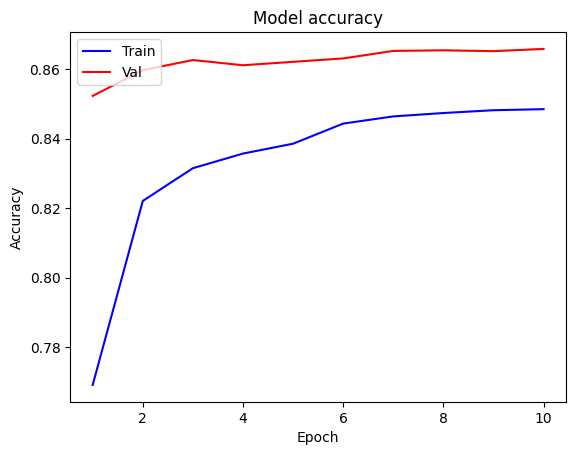

In [38]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

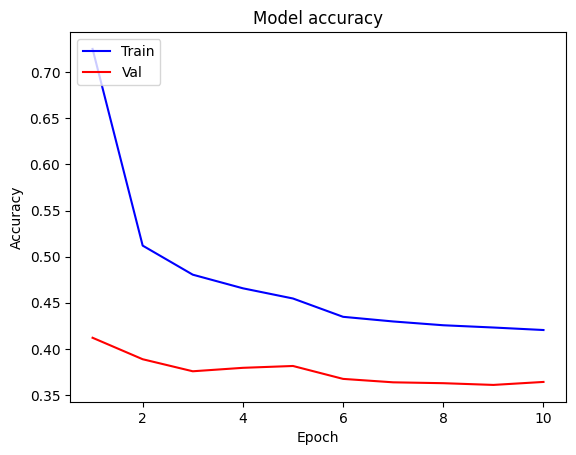

In [39]:
# loss curve
plotgraph(epochs, loss, val_loss)

### Interpretation:

- Grafik akurasi membantu kita melihat seberapa baik model tersebut belajar.
- Grafik lost membantu kita memeriksa apakah model mengalami overfitting atau underfitting.
- Idealnya, kurva pelatihan dan validasi harus berdekatan; jarak yang besar menunjukkan potensi overfitting.


## 4.3 Confusion Matrix

confusion matrix memberikan rincian prediksi yang benar dan salah berdasarkan kelas, sehingga memungkinkan kita untuk mengevaluasi kinerja model kita secara lebih komprehensif.

In [40]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_val)

# Convert predictions classes to one-hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert testing observations to one-hot vectors
Y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

2182/2182 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step


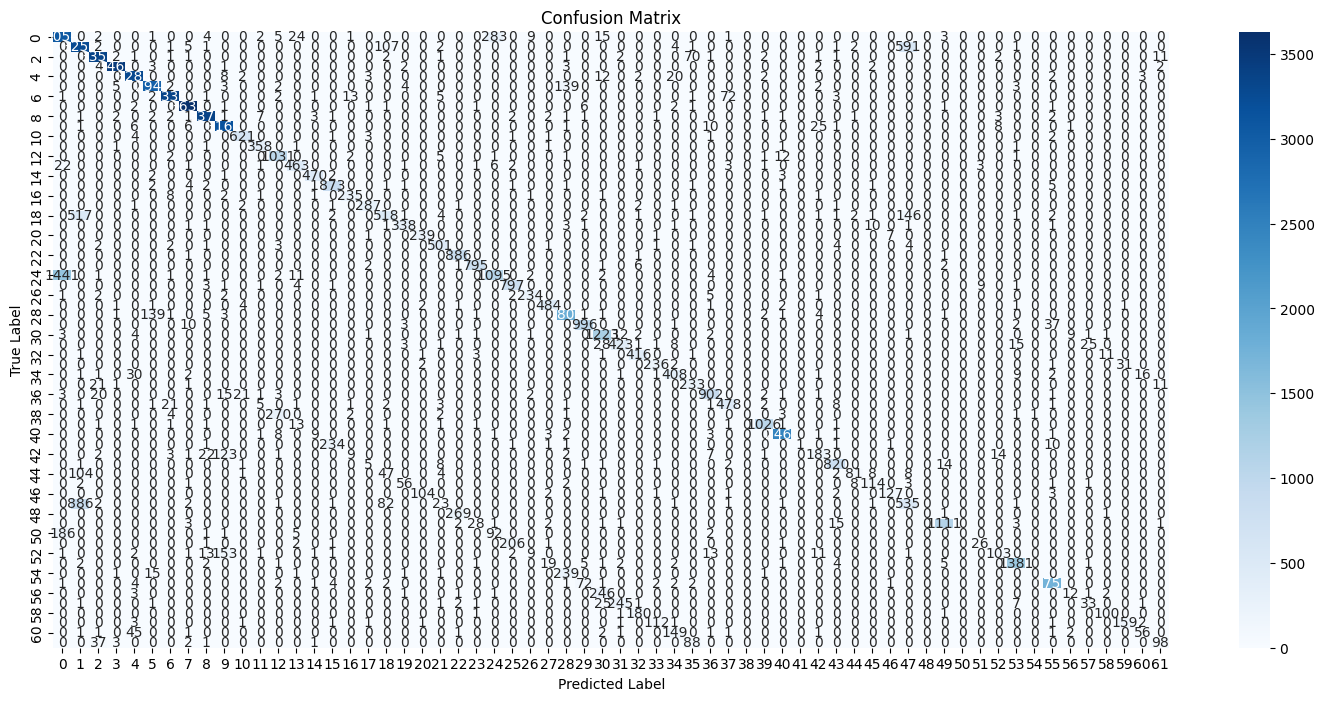

In [41]:
plt.figure(figsize=(18, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 4.4 Plot Correct and Misclassified Samples

In [42]:
correct = np.nonzero(Y_pred_classes == Y_true)[0]
misclassified = np.nonzero(Y_pred_classes != Y_true)[0]

print("Correctly predicted classes:", correct.shape[0])
print("Misclassified predicted classes:", misclassified.shape[0])

Correctly predicted classes: 60385
Misclassified predicted classes: 9409


In [43]:
def plot_images(data_index, cmap="Blues"):
    f, ax = plt.subplots(5, 5, figsize=(12, 12))
    for i, indx in enumerate(data_index[:25]):
        ax[i // 5, i % 5].imshow(x_val[indx].reshape(28, 28), cmap=cmap)
        ax[i // 5, i % 5].axis('off')
        true_label = label_dictionary[Y_true[indx]]
        pred_label = label_dictionary[Y_pred_classes[indx]]
        ax[i // 5, i % 5].set_title(f"True: {true_label}  Pred: {pred_label}")
    plt.show()

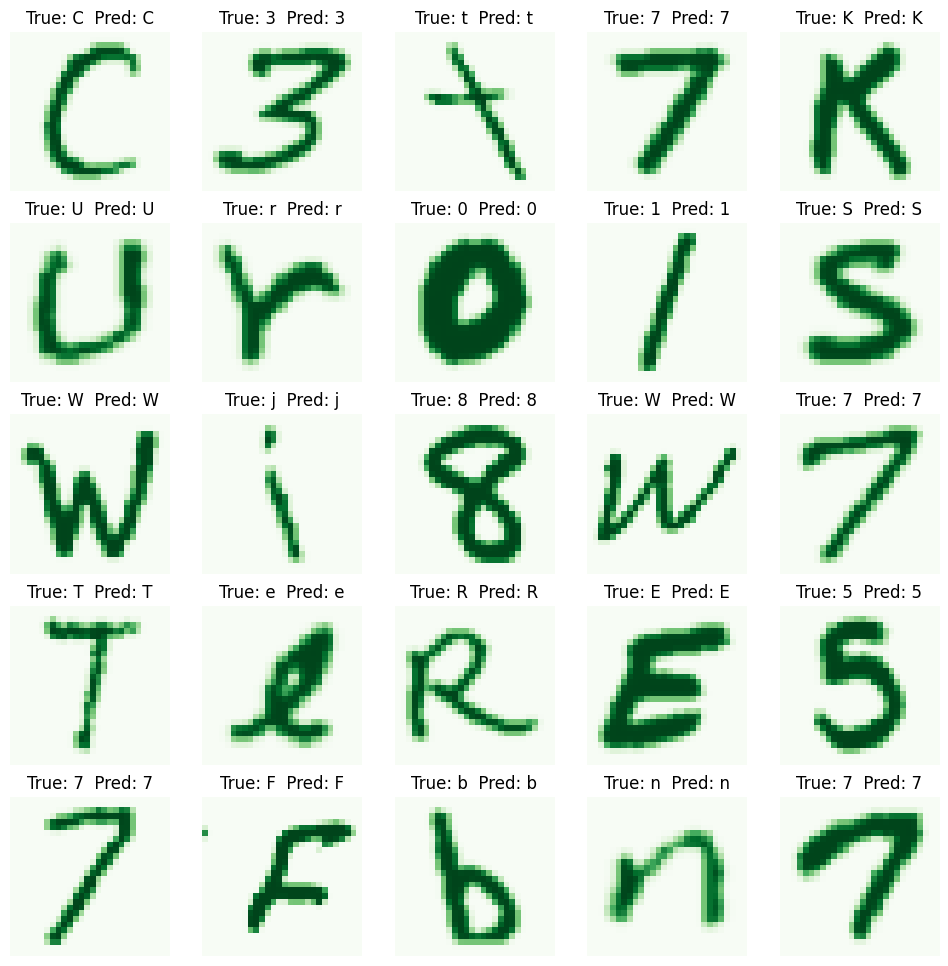

In [44]:
plot_images(correct, "Greens")

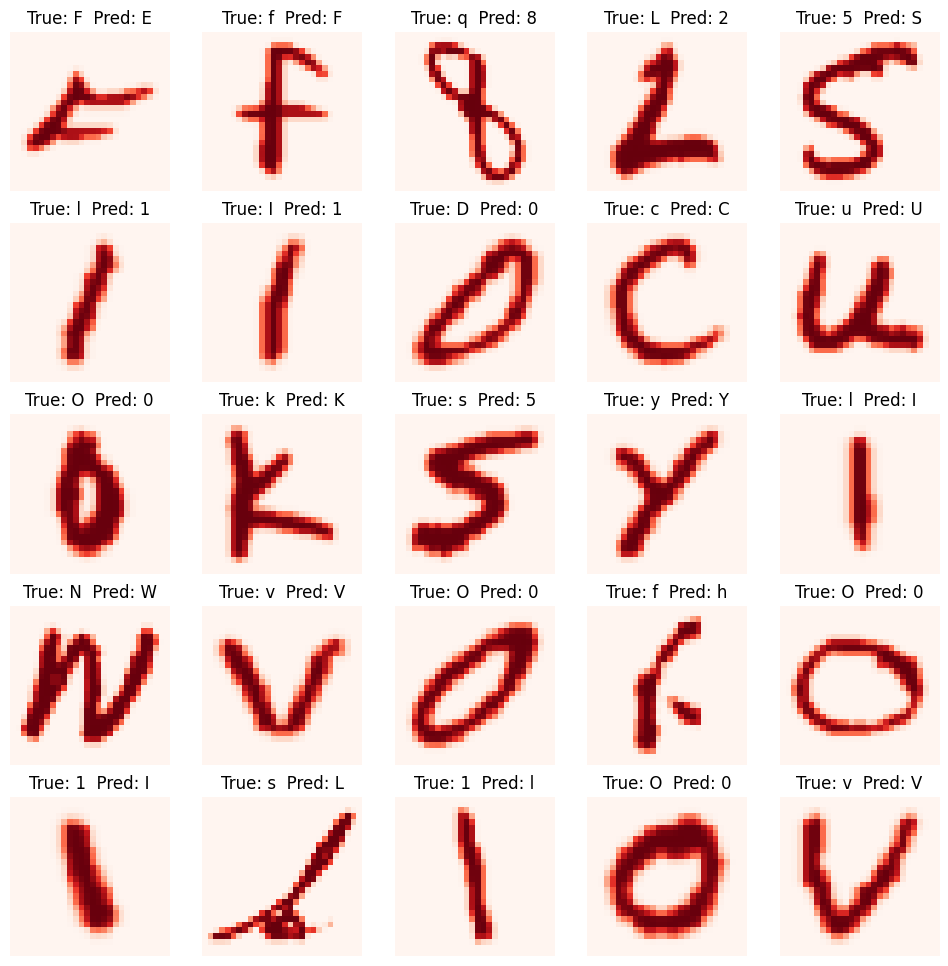

In [45]:
plot_images(misclassified, "Reds")

## 4.5 Save the Model

Setekah itu kita menyimpan model dalam format .h5 dan .keras (.keras untuk berjaga-jaga)

In [46]:
model.save('writing_recognition_model.h5')
print("Model saved successfully as 'writing_recognition_model.h5'")

Model saved successfully as 'writing_recognition_model.h5'


In [48]:
model.save('writing_recognition_model.keras')

In [49]:
# Load best model
loaded_model = load_model(r'C:\Users\LENOVO\tubesAILab\writing_recognition_model.keras')
loaded_model.summary()

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 62)                  │          15,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,430 (3.09 MB)

 Trainable params: 404,734 (1.54 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 404,736 (1.54 MB)

# 5. Prediction on the Validation Data

In [41]:
y_pred = loaded_model.predict(x_val)
y_pred.shape

270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


(8640, 36)

## 5.1 Visualizing some predicted values

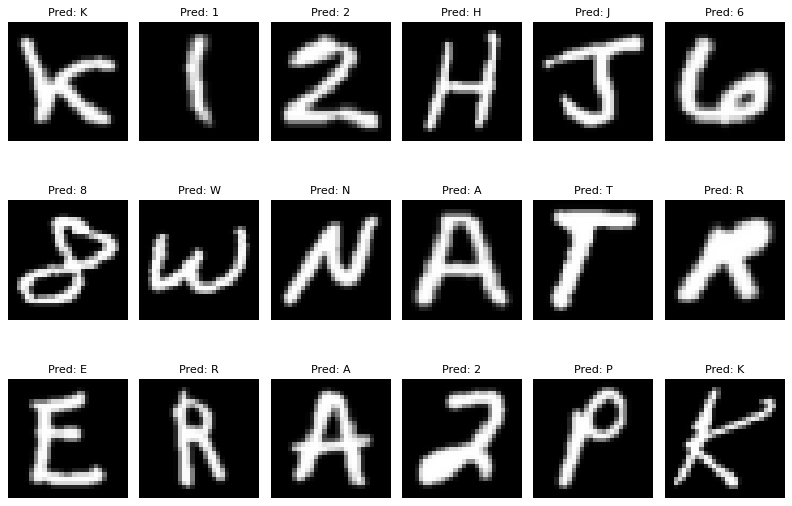

In [42]:
plt.figure(figsize=(10, 8), dpi=80)

for i in range(200, 218):
    plt.subplot(3, 6, i - 199)
    plt.imshow(x_val[i], cmap='gray')
    plt.title(f"Pred: {label_dictionary[y_pred[i].argmax()]}", fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5.2 Validation Accuracy

In [43]:
val_acc = loaded_model.evaluate(x_val, y_val)
print('Loss value is ',val_acc[0])
print('Accuracy value is ',val_acc[1])

270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8978 - loss: 0.2762
Loss value is  0.2854354679584503
Accuracy value is  0.8958333134651184


## 5.3 Predicting the test data

In [44]:
test_df = pd.read_csv(r'C:\Users\LENOVO\tubesAILab\emnist\emnist-byclass-test.csv', header=None)
test_df.shape

(18800, 785)

In [45]:
# Using ALL test data - 62 classes (numbers, uppercase, lowercase)
test_df_new = test_df.copy()
test_df_new.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,14400.000000,14400.0,14400.0,14400.0,14400.0,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,...,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0
mean,17.500000,0.0,0.0,0.0,0.0,0.007917,0.025764,0.014722,0.012222,0.014722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,10.388655,0.0,0.0,0.0,0.0,0.604236,2.012452,1.204803,1.019562,1.733652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8.750000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,17.500000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,26.250000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,35.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,108.000000,95.000000,208.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Splitting into x and y
x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]

x_test.shape, y_test.shape

((14400, 784), (14400,))

In [47]:
#Flipinng and rotating

x_test = np.apply_along_axis(flip_and_rotate, 1, x_test.values)
y_test = to_categorical(y_test, number_of_classes)

x_test.shape, y_test.shape

((14400, 28, 28), (14400, 36))

In [48]:
#Normalisation
x_test = x_test.astype('float32') / 255

In [49]:
#Reshaping (Changing Dimension)
x_test = x_test.reshape(-1, W, H, 1)
x_test.shape

(14400, 28, 28, 1)

In [50]:
#Evaluating Model
test_acc = loaded_model.evaluate(x_test, y_test)
print('Loss value is ',test_acc[0])
print('Accuracy value is ',test_acc[1])

450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8997 - loss: 0.2865
Loss value is  0.2866690456867218
Accuracy value is  0.8978472352027893


In [51]:
#Prediction
y_pred_test = loaded_model.predict(x_test)
y_pred_test.shape

450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


(14400, 36)

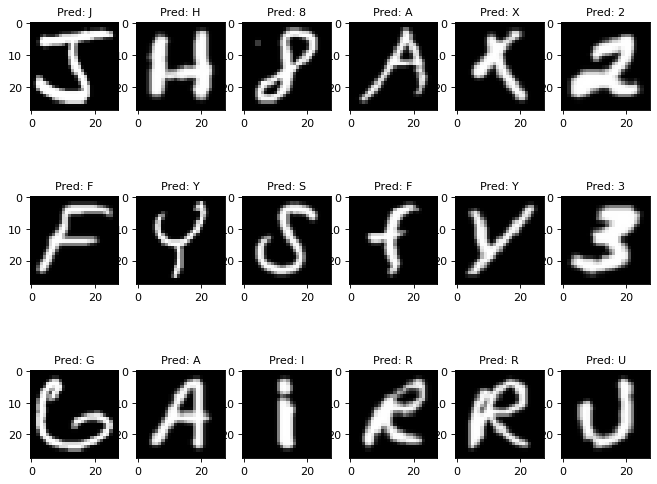

In [52]:
plt.figure(figsize=(10, 8), dpi=80)

for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(f"Pred: {label_dictionary[y_pred_test[i].argmax()]}", fontsize=10)

# 6. Testing on new image

## 6.1 Preprocessing the Image

- Konversi ke Skala Abu-abu
- Balikkan Warna (Hitam → Putih, Putih → Hitam)
- Ubah Ukuran menjadi 28×28 Piksel
- Ubah Bentuk agar Sesuai dengan Format Input Model

**Untuk lebih detail ada di cell paling bawah**

In [2]:
import os
print(os.path.exists(r'C:\Users\LENOVO\tubesAILab\sampleImages\drawing.jpg'))

True


In [4]:
import cv2
import numpy as np

img = cv2.imread(r'C:\Users\LENOVO\tubesAILab\sampleImages\digital_input.jpg')

# convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = 255 - gray

# resize image to 28x28 pixels
gray_resized = cv2.resize(gray, (28, 28))

# reshape image to ( , 28, 28, 1)
gray_reshaped = gray_resized.reshape(1, 28, 28, 1)

# display shape of reshaped image
print(gray_reshaped.shape)

(1, 28, 28, 1)


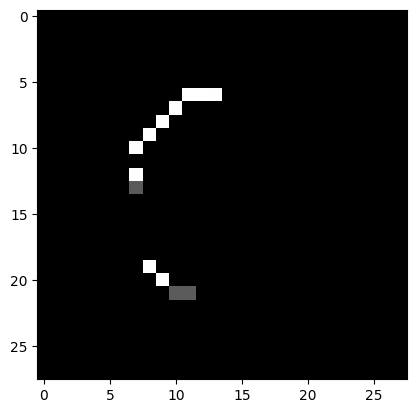

In [6]:
import matplotlib.pyplot as plt
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)

In [7]:
y_pred_test1 = loaded_model.predict(gray_reshaped)
y_pred_test1.shape

NameError: name 'loaded_model' is not defined

In [131]:
label_dictionary[y_pred_test1.argmax()]

'Q'

Text(0.5, 1.0, 'Q')

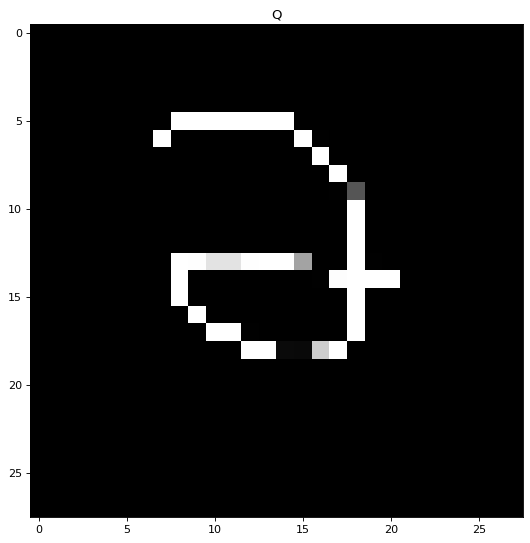

In [132]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)
plt.title(label_dictionary[y_pred_test1[0].argmax()])

# 7. Using with segmented images

In [133]:
import sys
import cv2 as cv
import numpy as np
from pathlib import Path
from IPython.display import Image, display
import glob
import matplotlib.pyplot as plt
import uuid
import datetime


def read(path):
    img = cv.imread(str(path), 0)
    if img is None:
        sys.exit("Error! Invalid path")
    return img


def resize(img, width=600):
    b = width
    a = b / img.shape[1]
    return cv.resize(img, (b, int(img.shape[0] * a)), interpolation=cv.INTER_AREA)


def apply_thresh(img):
    return cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 155, 20)

def get_box_coords(cnts):
    boxes = np.zeros((len(cnts), 4), dtype='uint8')
    for i, cnt in enumerate(cnts):
        x, y, w, h = cv.boundingRect(cnt)
        boxes[i] = x, y, w, h
    return boxes


def get_area_wise_order(cnts):
    areas = [cv.contourArea(cnt) for cnt in cnts]
    return np.argsort(areas)[::-1]


def squarify(img):
    axis_0, axis_1 = img.shape
    diff = np.abs(axis_0 - axis_1)
    pad_1 = diff // 2
    pad_2 = pad_1 + (diff % 2)
    if axis_0 > axis_1:
        return np.pad(img, ((0, 0), (pad_1, pad_2)), mode='constant', constant_values=255)
    else:
        return np.pad(img, ((pad_1, pad_2), (0, 0)), mode='constant', constant_values=255)


def get_symbol_order(boxes, threshold_y=20):
    boxes = np.array(boxes)
    
    # Get centers of all boxes
    centers = boxes[:, :2] + boxes[:, 2:] / 2
    
    # Group symbols by line based on y-coordinate
    lines = []
    current_line = [0]
    sorted_by_y = np.argsort(centers[:, 1])
    
    for idx in sorted_by_y[1:]:
        y_diff = abs(centers[idx, 1] - centers[current_line[0], 1])
        if y_diff <= threshold_y:
            current_line.append(idx)
        else:
            # Sort current line by x-coordinate
            current_line.sort(key=lambda i: centers[i, 0])
            lines.append(current_line)
            current_line = [idx]
    
    # Add last line
    if current_line:
        current_line.sort(key=lambda i: centers[i, 0])
        lines.append(current_line)
    
    # Flatten the lines into final order
    return [idx for line in lines for idx in line]

def generate_equation_name():
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    short_uuid = str(uuid.uuid4())[:8]
    return f"equation_{timestamp}_{short_uuid}"



def save_all_masks(img, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    # Find contours
    cnts, _ = cv.findContours(255 - img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    pad_x = 2
    pad_y = 2
    
    # Create initial mask
    mask = np.ones(img.shape, np.uint8) * 255
    for cnt in cnts:
        cv.drawContours(mask, [cnt], 0, (0, 0, 0), -1)
    
    # Process contours
    cnts, _ = cv.findContours(255 - mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnts = list(cnts)
    
    # Get bounding boxes and filter by size
    boxes = []
    symbols = []
    temp = img.copy()
    max_size = max(cv.contourArea(cnt) for cnt in cnts)
    
    for cnt in cnts:
        if cv.contourArea(cnt) > max_size / 20:  # Filter out noise
            x, y, w, h = cv.boundingRect(cnt)
            boxes.append([x, y, w, h])
            
            # Extract and process symbol
            symbol = temp[y:y + h, x:x + w]
            symbol = np.pad(symbol, ((pad_y, pad_y), (pad_x, pad_x)), 
                          mode='constant', constant_values=255)
            symbol = squarify(symbol)
            symbols.append(symbol)
            
            # Mark processed region
            temp[y:y + h, x:x + w] = 255
    
    # Get correct symbol order
    order = get_symbol_order(boxes)
    
    # Save symbols in correct order and draw boxes
    ordered_paths = []
    for i, idx in enumerate(order):
        # Save symbol
        symbol_path = str(Path(output_dir) / f'{i:03d}.png')
        cv.imwrite(symbol_path, symbols[idx])
        ordered_paths.append(symbol_path)
        
        # Draw box with order number
        x, y, w, h = boxes[idx]
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv.putText(img, str(i), (x, y - 5), 
                  cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Save image with numbered boxes
    cv.imwrite(str(Path(output_dir) / 'image_with_boxes.png'), img)
    
    return ordered_paths

def process_equation(img_path):
    equation_name = generate_equation_name()
    output_dir = Path("/kaggle/working/output") / equation_name
    
    # Read and process the image
    img = read(img_path)
    resize_img = resize(img, 600)
    temp = apply_thresh(resize_img)
    
    # Save the segmented symbols and get their paths in order
    ordered_paths = save_all_masks(temp, output_dir)
    
    return output_dir, ordered_paths

In [135]:
img_path = r'C:\Users\LENOVO\tubesAILab\sampleImages\digital_input.jpg'
output_dir, ordered_paths = process_equation(img_path)
print(f"Processed symbols saved to: {output_dir}")
print(output_dir)
print(ordered_paths)

Processed symbols saved to: \kaggle\working\output\equation_20260128_110232_37ea685b
\kaggle\working\output\equation_20260128_110232_37ea685b
['\\kaggle\\working\\output\\equation_20260128_110232_37ea685b\\000.png']


(np.float64(-0.5), np.float64(599.5), np.float64(239.5), np.float64(-0.5))

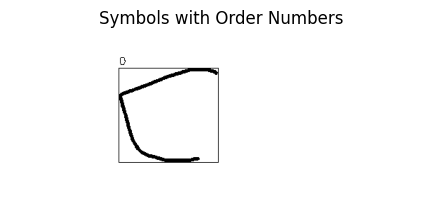

In [136]:
boxes_img = cv.imread(str(output_dir / 'image_with_boxes.png'))
boxes_img = cv.cvtColor(boxes_img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(boxes_img)
plt.title('Symbols with Order Numbers')
plt.axis('off')

In [137]:
def predict_equation_symbols(model, ordered_paths, label_dictionary):
    predictions = []
    
    for path in ordered_paths:
        img = cv2.imread(path)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = 255 - gray
        
        # Resize image to 28x28 pixels
        gray_resized = cv2.resize(gray, (28, 28))
        
        # Reshape image to (1, 28, 28, 1) for model input
        gray_reshaped = gray_resized.reshape(1, 28, 28, 1)
        
        prediction = model.predict(gray_reshaped)
        predicted_label = label_dictionary[prediction.argmax()]
        
        predictions.append(predicted_label)
    
    return predictions

In [138]:
predicted_symbols = predict_equation_symbols(loaded_model, ordered_paths, label_dictionary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [139]:
predicted_symbols

['C']

# 8. Using Merged Dataset with Symbols

In [140]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25857 sha256=74bd88e45855172d110881ac56882fc0dea903944a46539644a9208d0ca4ce9e
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils


In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [4]:
x = []
y = []
datadir = r'C:\Users\LENOVO\tubesAILab\math\data\extracted_images'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

375974
375974
labels : ['8', 'in', ')', '}', 'int', 'H', 'z', 'j', '+', 'w', 'k', 'p', 'G', 'T', '0', 'sigma', 'ldots', 'q', 'C', 'o', 'infty', 'pm', 'theta', 'y', '1', 'forall', 'i', 'b', 'lim', 'sqrt', 'rightarrow', ',', '[', 'A', 'prime', 'neq', 'gt', 'd', 'Delta', 'times', 'log', '3', 'M', 'v', 'lt', 'f', 'sum', 'alpha', 'pi', 'R', 'ascii_124', '2', 'exists', 'N', 'beta', '=', '!', 'div', '9', 'sin', '(', 'gamma', '5', 'leq', '4', 'forward_slash', 'phi', 'u', 'cos', 'S', '6', 'l', 'X', '{', 'lambda', 'mu', '7', ']', '-', 'geq', 'e', 'tan']


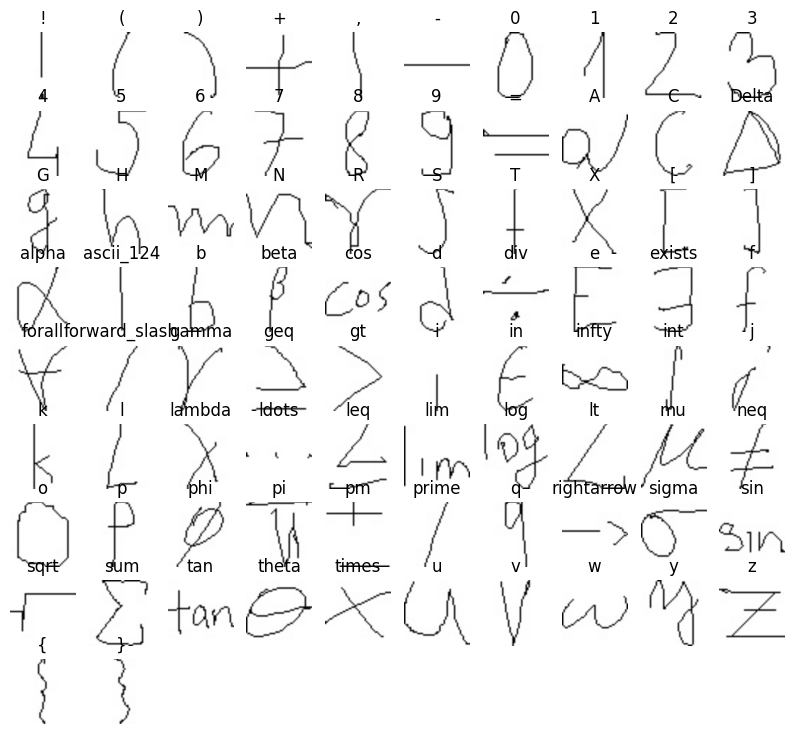

In [5]:
figure = plt.figure(figsize=(10, 10))
j = 0

for i in sorted(set(y)):
    if j == 100:  # sekarang maksimal 100 gambar
        break

    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    figure.add_subplot(10, 10, j+1)  # grid 10x10 = 100 slot
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

    j += 1



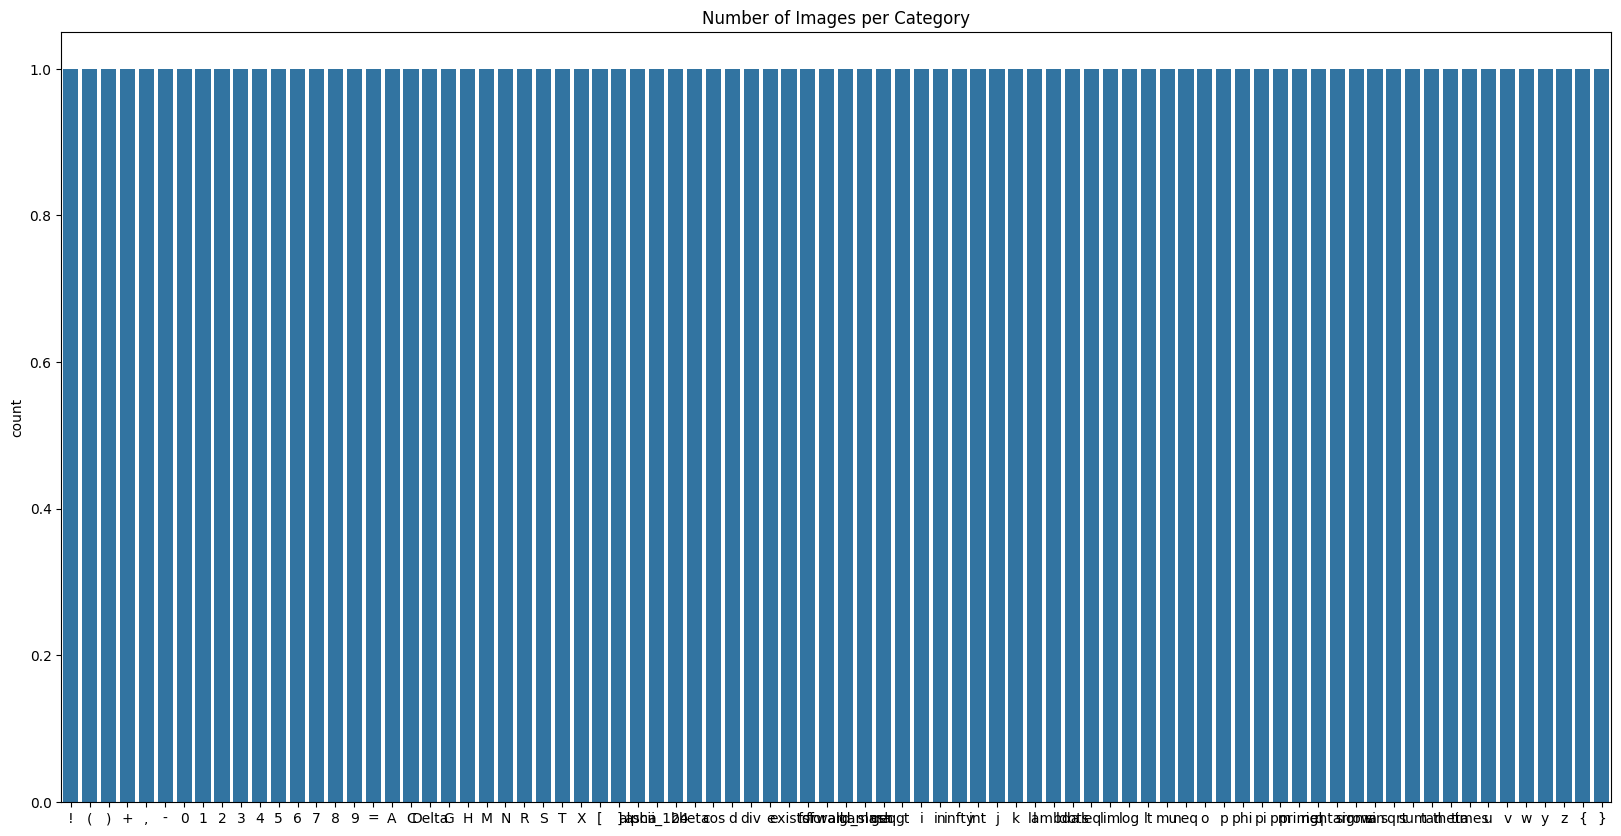

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sns.countplot(x=unique)
plt.title('Number of Images per Category')
plt.show()

In [7]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

375974


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

375974


In [9]:
# Di bawah label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Total classes detected: {num_classes}")

Total classes detected: 82


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

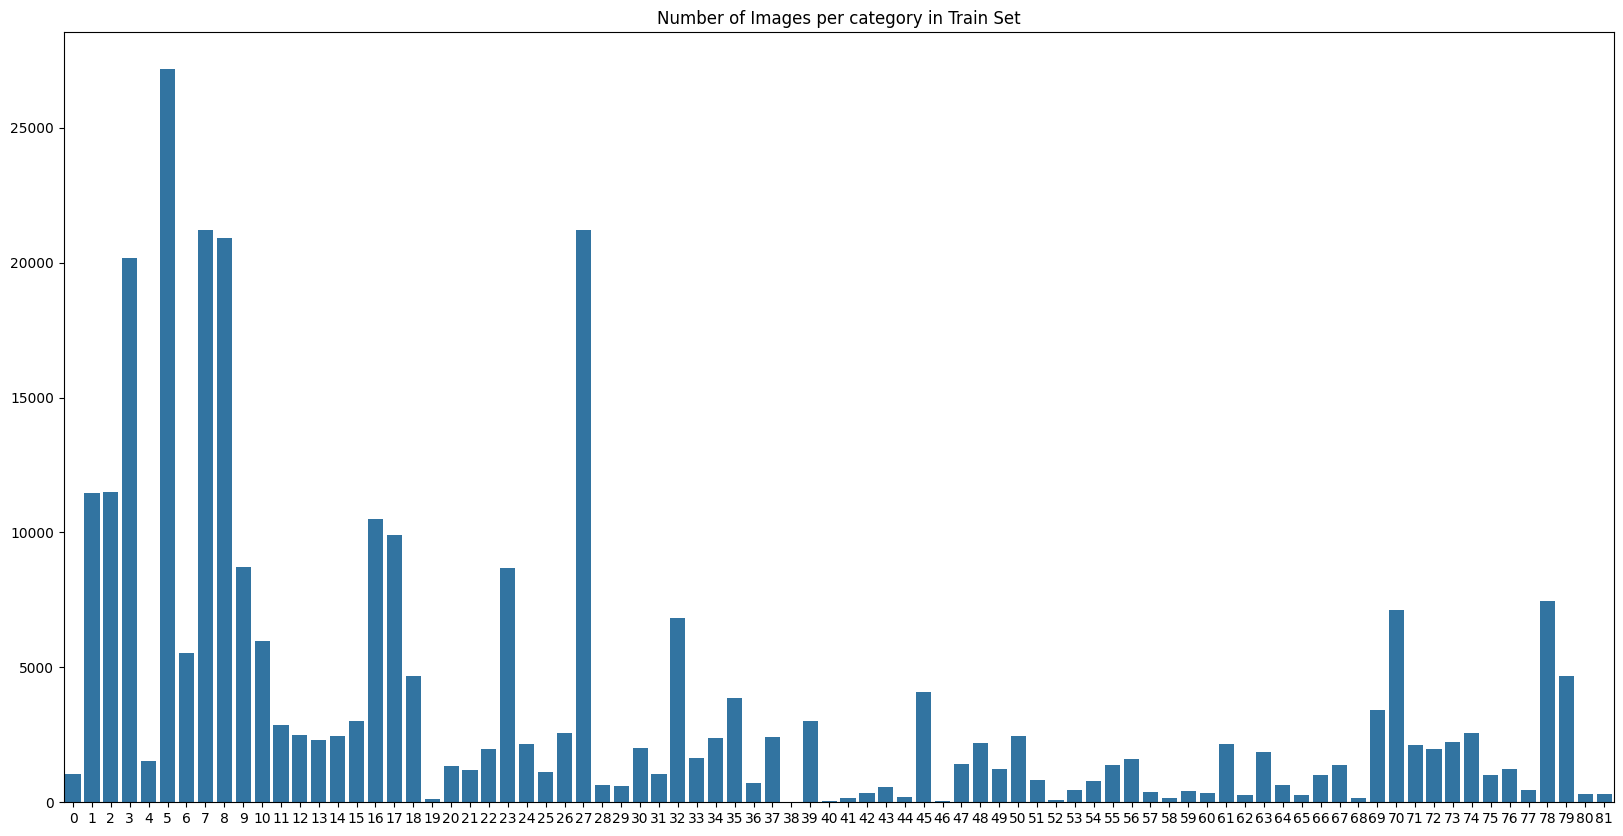

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_train, y=count_train)
ax.set_title('Number of Images per category in Train Set')
plt.show()

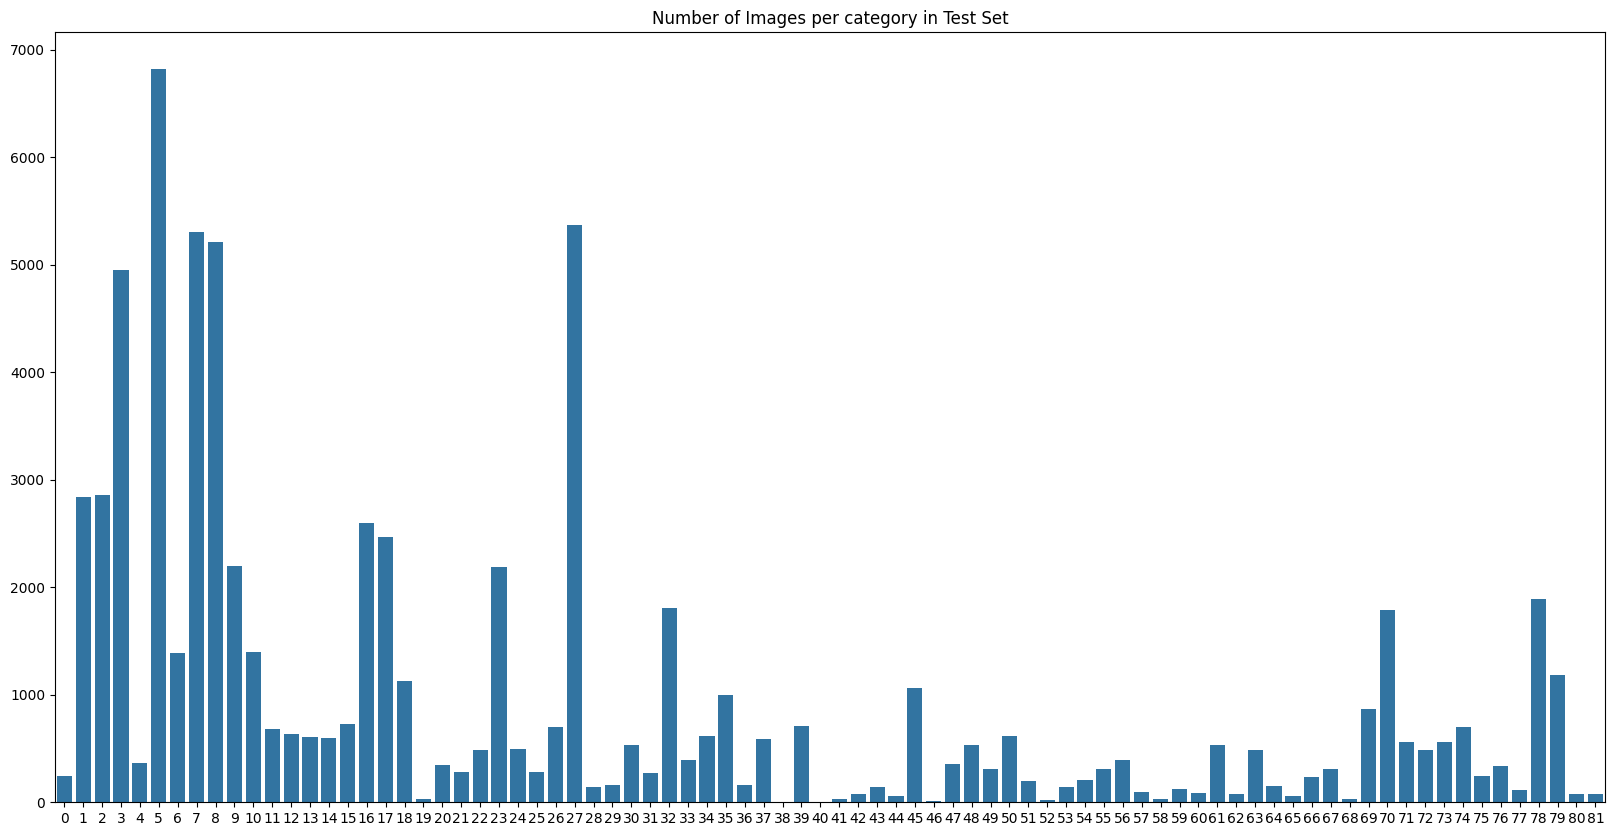

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_test, y=count_test)
ax.set_title('Number of Images per category in Test Set')
plt.show()

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(300779, 32, 32, 1)
(75195, 32, 32, 1)
(300779, 82)
(75195, 82)


In [14]:
# Tambahkan parameter num_classes di sini
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1), num_classes=10):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1), num_classes=num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act1 (Activation)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act2 (Activation)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act3 (Activation)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 120)                 │         123,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 82)                  │           6,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,198 (657.02 KB)

 Trainable params: 168,198 (657.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=20, validation_data=(X_test, Y_test))

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 262s 109ms/step - accuracy: 0.3017 - loss: 5.9052 - val_accuracy: 0.7599 - val_loss: 1.0687
Epoch 2/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 259s 110ms/step - accuracy: 0.7269 - loss: 1.1459 - val_accuracy: 0.8167 - val_loss: 0.8851
Epoch 3/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 260s 110ms/step - accuracy: 0.7954 - loss: 0.8742 - val_accuracy: 0.8515 - val_loss: 0.6978
Epoch 4/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 266s 113ms/step - accuracy: 0.8216 - loss: 0.7644 - val_accuracy: 0.8707 - val_loss: 0.6275
Epoch 5/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 264s 112ms/step - accuracy: 0.8388 - loss: 0.6946 - val_accuracy: 0.8876 - val_loss: 0.5303
Epoch 6/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 353s 150ms/step - accuracy: 0.8489 - loss: 0.6603 - val_accuracy: 0.8966 - val_loss: 0.5237
Epoch 7/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 365s 155ms/step - accuracy: 0.8553 - loss: 0.6280 - val_accuracy: 0.9044 - val_loss: 0.4899
Epoch 8/20
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 364s 155ms/step - ac

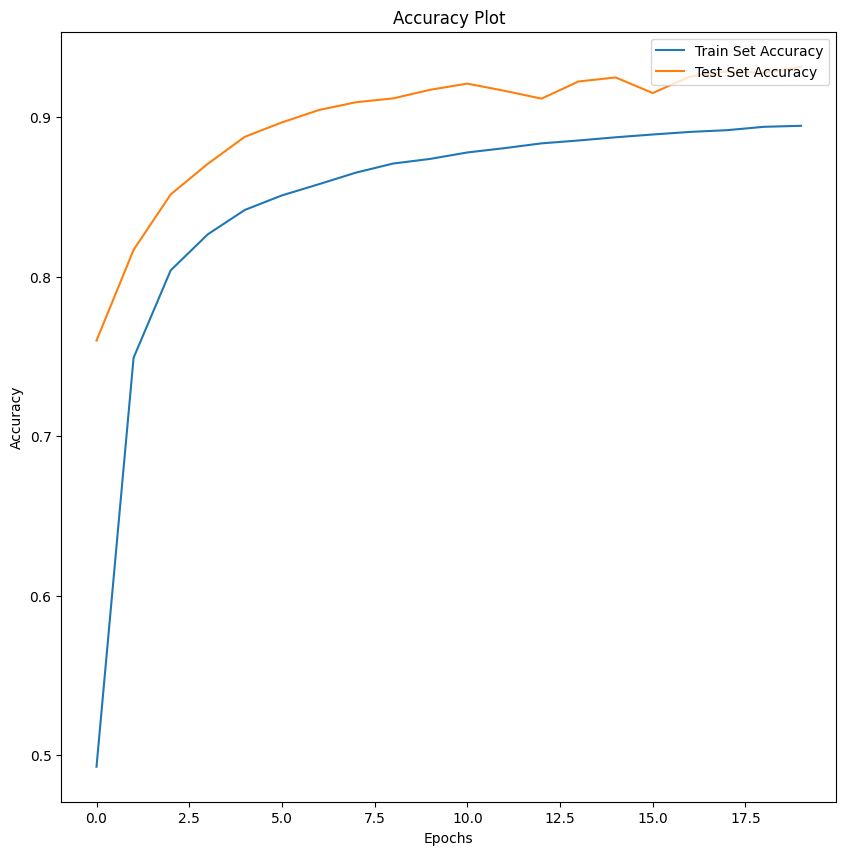

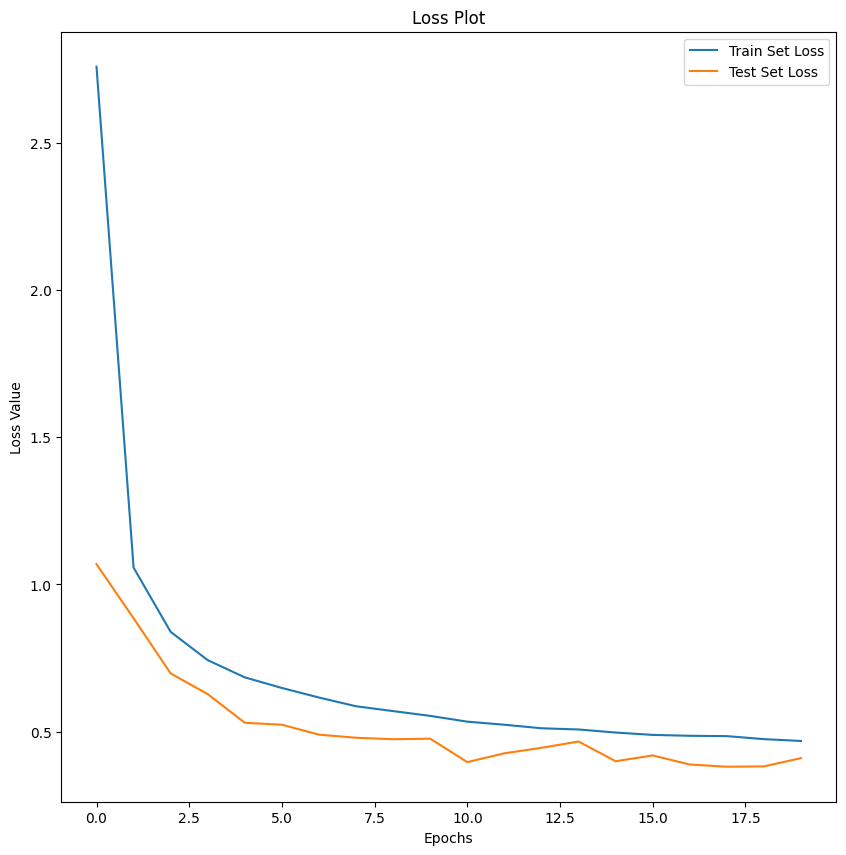

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

2350/2350 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       244
           1       0.93      0.96      0.94      2838
           2       0.93      0.98      0.96      2861
           3       0.99      0.98      0.98      4947
           4       0.67      0.28      0.39       366
           5       0.99      0.99      0.99      6821
           6       0.91      0.98      0.94      1392
           7       0.87      0.94      0.90      5306
           8       0.95      0.97      0.96      5212
           9       0.95      0.99      0.97      2197
          10       0.97      0.95      0.96      1402
          11       0.82      0.93      0.87       680
          12       0.89      0.95      0.92       637
          13       0.93      0.90      0.91       608
          14       0.92      0.94      0.93       596
          15       0.75      0.93      0.83       732
          16       0.99      0.99    

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [19]:
model.save('maths_symbol_and_digits_recognition.h5')

In [27]:
model.save('maths_symbol_and_digits_recognition.keras')

In [28]:
from tensorflow.keras.models import load_model

# Setelah di-import, baru jalankan kode load-nya:
loaded_model = load_model(r'C:\Users\LENOVO\tubesAILab\maths_symbol_and_digits_recognition.keras')
loaded_model.summary()

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act1 (Activation)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act2 (Activation)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act3 (Activation)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 120)                 │         123,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 82)                  │           6,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,398 (1.28 MB)

 Trainable params: 168,198 (657.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,200 (657.04 KB)

In [31]:
def predict_symbol(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image {image_path}")
        return None, 0

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    img = cv2.resize(img, (32, 32))

    img = img.astype('float32') / 255.0

    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)

    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # --- BAGIAN INI YANG DIPERBAIKI ---
    # Jangan pakai list manual ['0', '1', ...]
    # Gunakan label_encoder untuk mendapatkan nama kelas asli secara otomatis
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    # ----------------------------------

    confidence = predictions[0][predicted_class_idx]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    orig_img = cv2.imread(image_path)
    if len(orig_img.shape) == 3:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title("Processed Input")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Predicted: {predicted_class}\nConfidence: {confidence:.4f}",
             ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return predicted_class, confidence

In [35]:
# Ubah .jpg menjadi .png
predicted_class, confidence = predict_symbol(r'C:\Users\LENOVO\tubesAILab\sampleImages\drawing.jpg')

print(predicted_class)
print(confidence)

Error: Could not load image C:\Users\LENOVO\tubesAILab\sampleImages\drawing.jpg
None
0


In [36]:
import os
path = r'C:\Users\LENOVO\tubesAILab\sampleImages\drawing.jpg' # Coba drawing.png

if os.path.exists(path):
    print("✅ File ditemukan!")
else:
    print("❌ File tidak ditemukan. Cek nama dan ekstensinya lagi.")
    # List file di folder tersebut untuk memastikan
    folder = r'C:\Users\LENOVO\tubesAILab\sampleImages'
    if os.path.exists(folder):
        print("Isi folder:", os.listdir(folder))

✅ File ditemukan!


UJI COBA SEMUA MODEL 

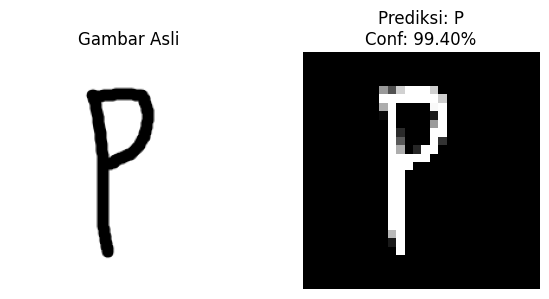


🎯 Prediksi Karakter : P
📊 Confidence        : 99.40%


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import os

# ================== LOAD MODEL ==================
model = load_model('writing_recognition_model.h5')

# ================== LOAD LABEL MAP ==================
label_map = pd.read_csv(
    r'C:\Users\LENOVO\tubesAILab\emnist\emnist-byclass-mapping.txt',
    delimiter=' ',
    index_col=0,
    header=None
)

label_dictionary = {index: chr(label) for index, label in enumerate(label_map[1])}

# ================== FUNCTION PREDICT ==================
def predict_handwriting(image_path):
    import os

    if not os.path.exists(image_path):
        print("❌ File tidak ditemukan:", image_path)
        return None, None

    img = cv2.imread(image_path)

    if img is None:
        print("❌ Gagal membaca gambar.")
        return None, None

    # Simpan versi asli untuk ditampilkan
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = 255 - gray  # invert warna (EMNIST style)

    resized = cv2.resize(gray, (28, 28))
    normalized = resized / 255.0
    preprocessed = normalized.reshape(1, 28, 28, 1)

    # Predict
    prediction = model.predict(preprocessed, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = float(prediction[0][predicted_class])
    predicted_char = label_dictionary.get(predicted_class, "?")

    # ================== TAMPILKAN HASIL ==================
    plt.figure(figsize=(6,3))

    # Gambar asli
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Gambar Asli")
    plt.axis("off")

    # Gambar setelah preprocessing
    plt.subplot(1,2,2)
    plt.imshow(resized, cmap='gray')
    plt.title(f"Prediksi: {predicted_char}\nConf: {confidence*100:.2f}%")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_char, confidence



# ================== TEST GAMBAR ==================
image_path = r'C:\Users\LENOVO\tubesAILab\sampleImages\drawing.png'

predicted_char, confidence = predict_handwriting(image_path)

if predicted_char is not None:
    print(f"\n🎯 Prediksi Karakter : {predicted_char}")
    print(f"📊 Confidence        : {confidence*100:.2f}%")



📂 File: 0.png


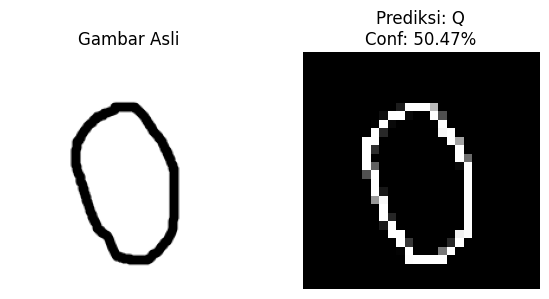

🔎 Prediksi : Q
🎯 Asli     : 0
📊 Confidence: 50.47%
❌ SALAH

📂 File: 1.png


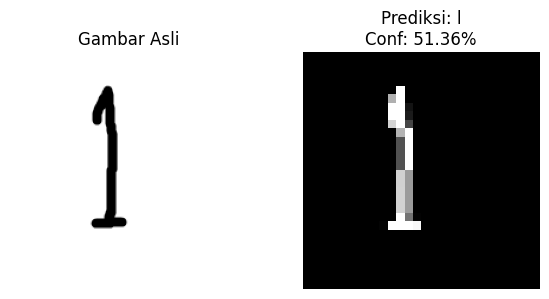

🔎 Prediksi : l
🎯 Asli     : 1
📊 Confidence: 51.36%
❌ SALAH

📂 File: 2.png


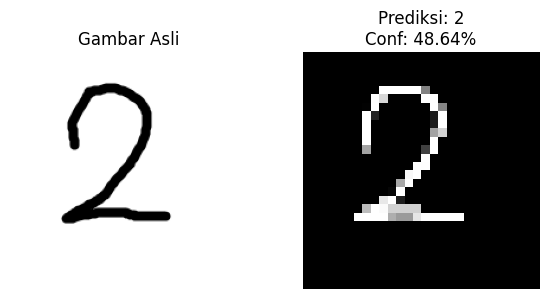

🔎 Prediksi : 2
🎯 Asli     : 2
📊 Confidence: 48.64%
✅ BENAR

📂 File: 3.png


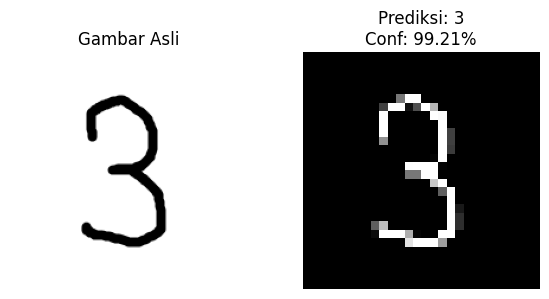

🔎 Prediksi : 3
🎯 Asli     : 3
📊 Confidence: 99.21%
✅ BENAR

📂 File: 4.png


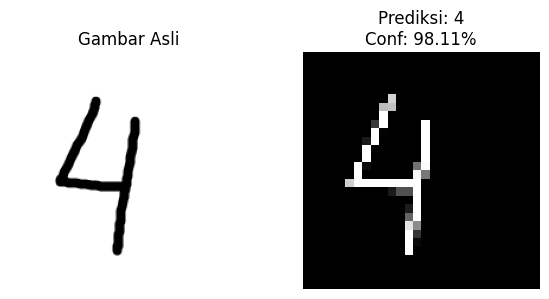

🔎 Prediksi : 4
🎯 Asli     : 4
📊 Confidence: 98.11%
✅ BENAR

📂 File: 5.png


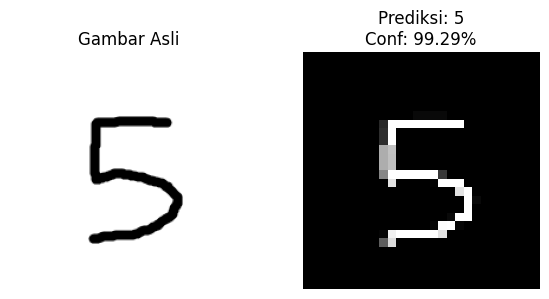

🔎 Prediksi : 5
🎯 Asli     : 5
📊 Confidence: 99.29%
✅ BENAR

📂 File: 6.png


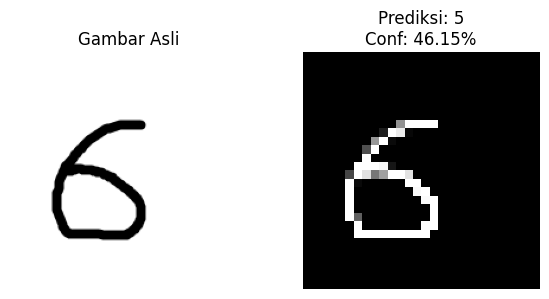

🔎 Prediksi : 5
🎯 Asli     : 6
📊 Confidence: 46.15%
❌ SALAH

📂 File: 7.png


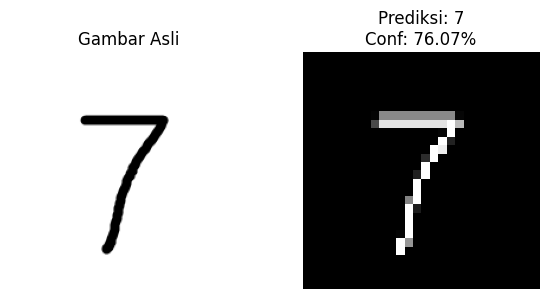

🔎 Prediksi : 7
🎯 Asli     : 7
📊 Confidence: 76.07%
✅ BENAR

📂 File: 8.png


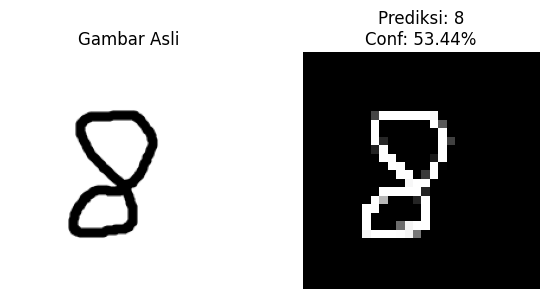

🔎 Prediksi : 8
🎯 Asli     : 8
📊 Confidence: 53.44%
✅ BENAR

📂 File: 9.png


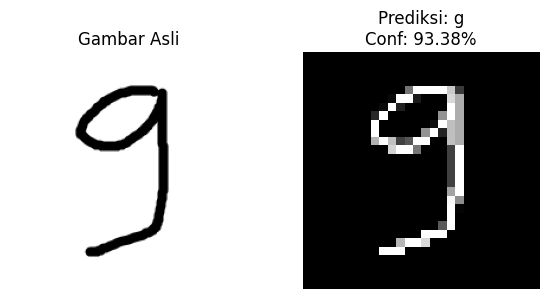

🔎 Prediksi : g
🎯 Asli     : 9
📊 Confidence: 93.38%
❌ SALAH

📂 File: A.jpg


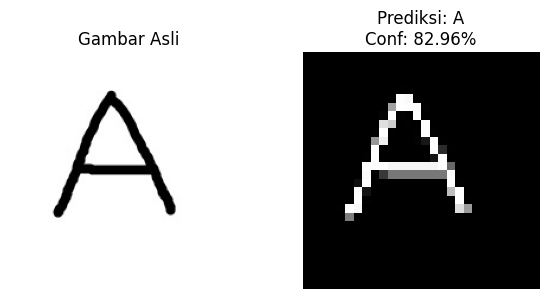

🔎 Prediksi : A
🎯 Asli     : A
📊 Confidence: 82.96%
✅ BENAR

📂 File: a.png


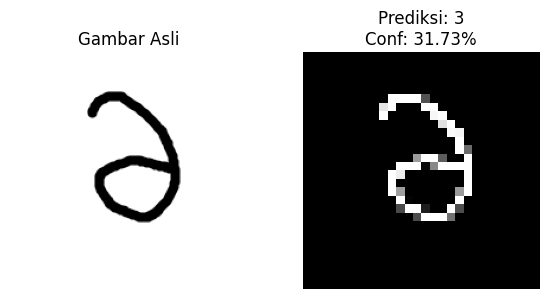

🔎 Prediksi : 3
🎯 Asli     : a
📊 Confidence: 31.73%
❌ SALAH

📂 File: B.jpg


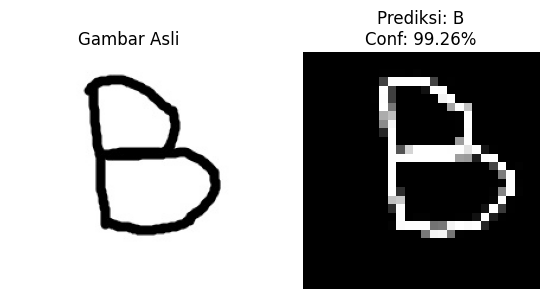

🔎 Prediksi : B
🎯 Asli     : B
📊 Confidence: 99.26%
✅ BENAR

📂 File: b.png


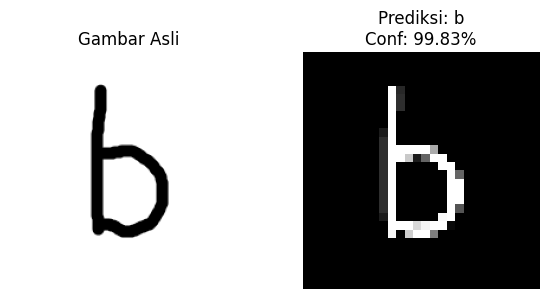

🔎 Prediksi : b
🎯 Asli     : b
📊 Confidence: 99.83%
✅ BENAR

📂 File: C.jpg


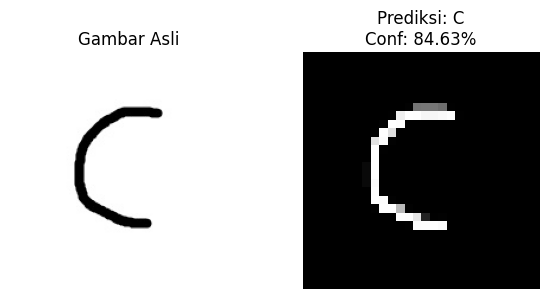

🔎 Prediksi : C
🎯 Asli     : C
📊 Confidence: 84.63%
✅ BENAR

📂 File: c.png


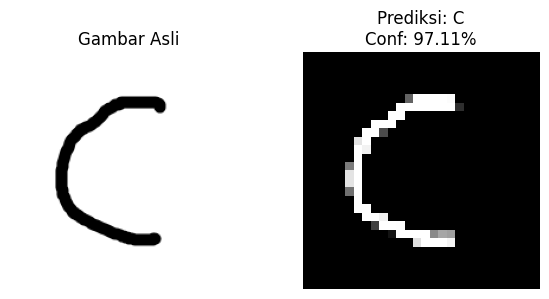

🔎 Prediksi : C
🎯 Asli     : c
📊 Confidence: 97.11%
❌ SALAH

📂 File: D.jpg


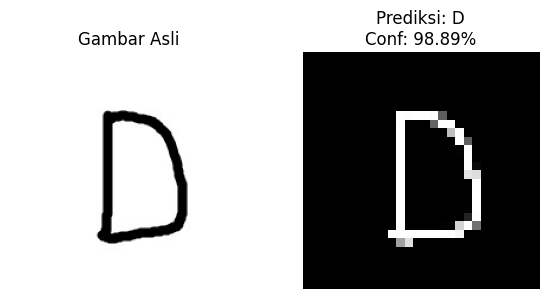

🔎 Prediksi : D
🎯 Asli     : D
📊 Confidence: 98.89%
✅ BENAR

📂 File: d.png


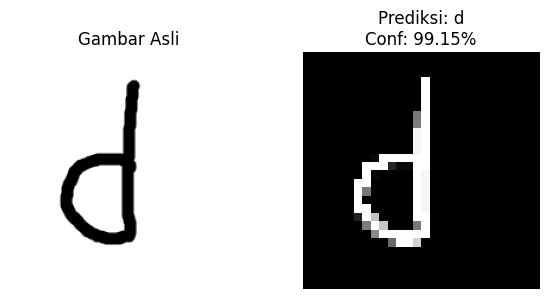

🔎 Prediksi : d
🎯 Asli     : d
📊 Confidence: 99.15%
✅ BENAR

📂 File: E.jpg


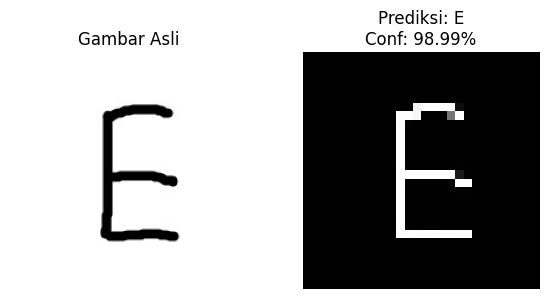

🔎 Prediksi : E
🎯 Asli     : E
📊 Confidence: 98.99%
✅ BENAR

📂 File: e.png


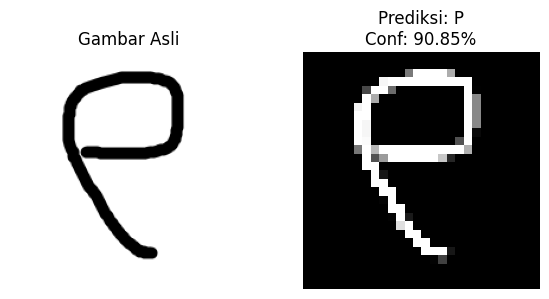

🔎 Prediksi : P
🎯 Asli     : e
📊 Confidence: 90.85%
❌ SALAH

📂 File: F.jpg


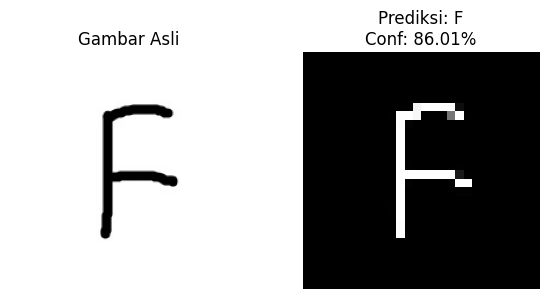

🔎 Prediksi : F
🎯 Asli     : F
📊 Confidence: 86.01%
✅ BENAR

📂 File: f.png


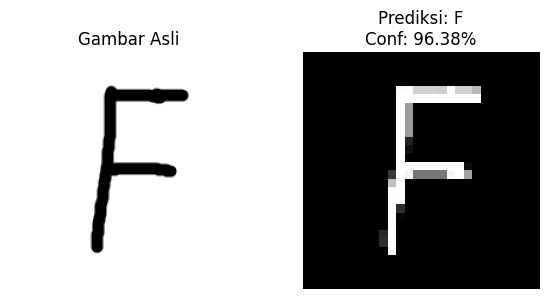

🔎 Prediksi : F
🎯 Asli     : f
📊 Confidence: 96.38%
❌ SALAH

📂 File: G.jpg


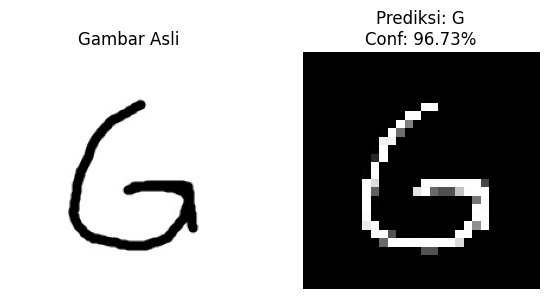

🔎 Prediksi : G
🎯 Asli     : G
📊 Confidence: 96.73%
✅ BENAR

📂 File: g.png


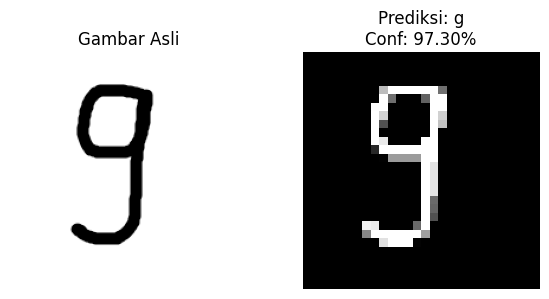

🔎 Prediksi : g
🎯 Asli     : g
📊 Confidence: 97.30%
✅ BENAR

📂 File: H.jpg


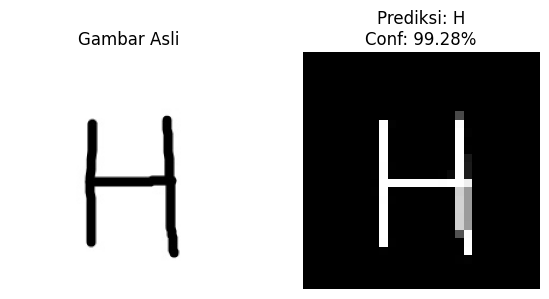

🔎 Prediksi : H
🎯 Asli     : H
📊 Confidence: 99.28%
✅ BENAR

📂 File: h.png


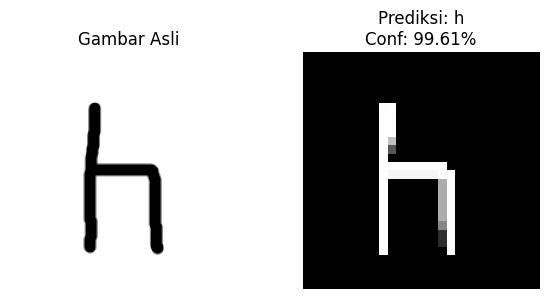

🔎 Prediksi : h
🎯 Asli     : h
📊 Confidence: 99.61%
✅ BENAR

📂 File: I.jpg


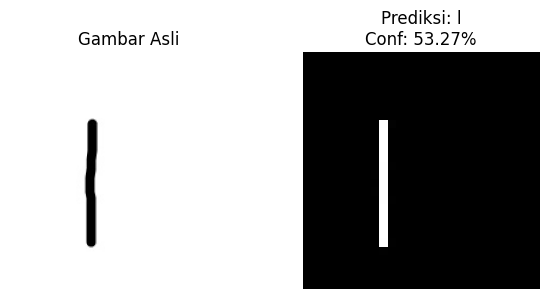

🔎 Prediksi : l
🎯 Asli     : I
📊 Confidence: 53.27%
❌ SALAH

📂 File: i.png


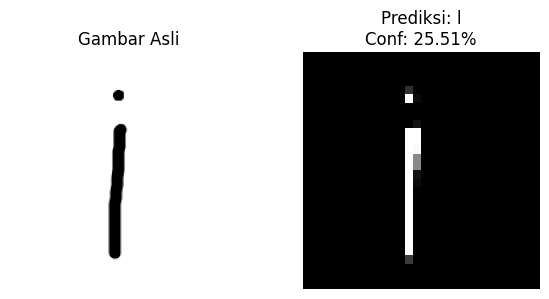

🔎 Prediksi : l
🎯 Asli     : i
📊 Confidence: 25.51%
❌ SALAH

📂 File: J.jpg


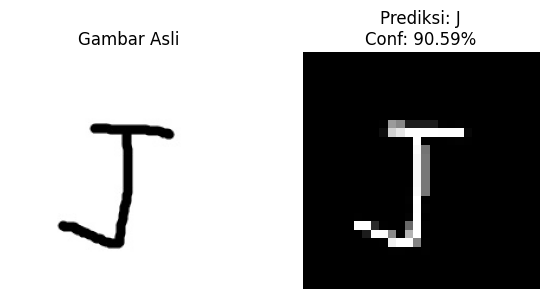

🔎 Prediksi : J
🎯 Asli     : J
📊 Confidence: 90.59%
✅ BENAR

📂 File: j.png


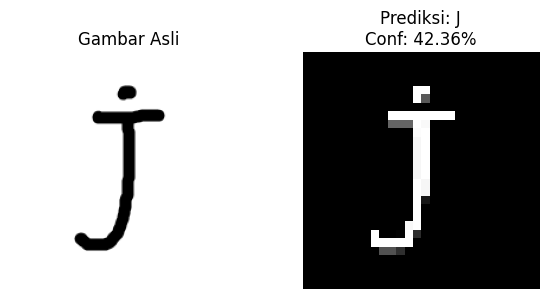

🔎 Prediksi : J
🎯 Asli     : j
📊 Confidence: 42.36%
❌ SALAH

📂 File: K.jpg


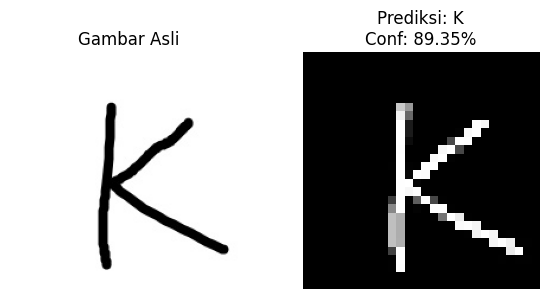

🔎 Prediksi : K
🎯 Asli     : K
📊 Confidence: 89.35%
✅ BENAR

📂 File: k.png


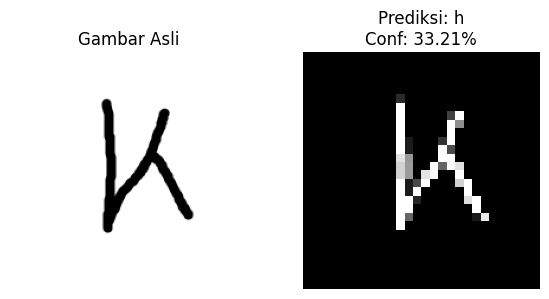

🔎 Prediksi : h
🎯 Asli     : k
📊 Confidence: 33.21%
❌ SALAH

📂 File: L.jpg


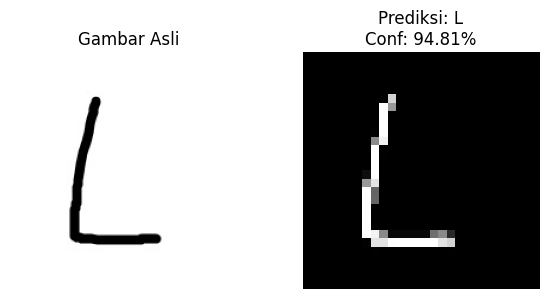

🔎 Prediksi : L
🎯 Asli     : L
📊 Confidence: 94.81%
✅ BENAR

📂 File: l.png


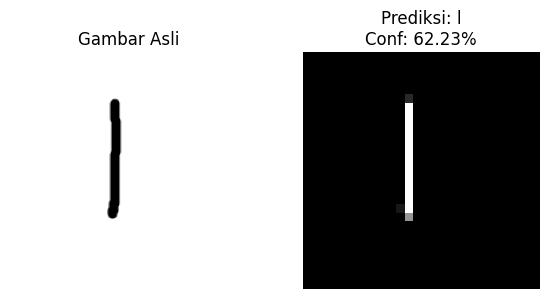

🔎 Prediksi : l
🎯 Asli     : l
📊 Confidence: 62.23%
✅ BENAR

📂 File: M.jpg


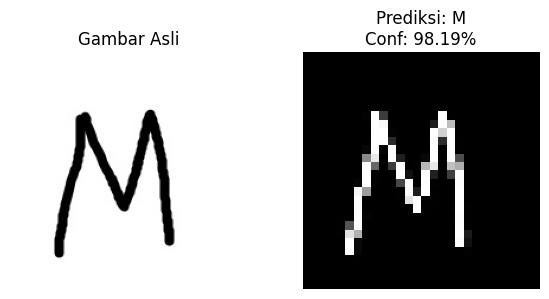

🔎 Prediksi : M
🎯 Asli     : M
📊 Confidence: 98.19%
✅ BENAR

📂 File: m.png


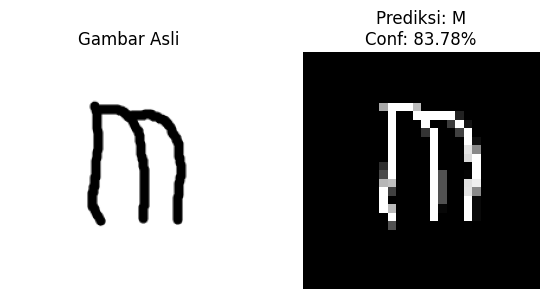

🔎 Prediksi : M
🎯 Asli     : m
📊 Confidence: 83.78%
❌ SALAH

📂 File: N.jpg


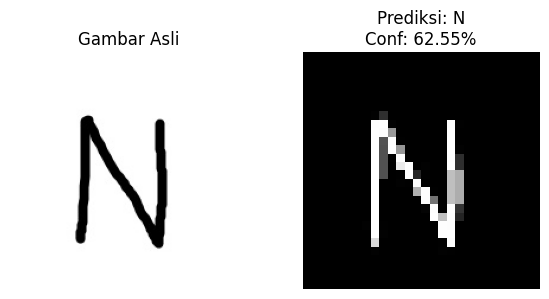

🔎 Prediksi : N
🎯 Asli     : N
📊 Confidence: 62.55%
✅ BENAR

📂 File: n.png


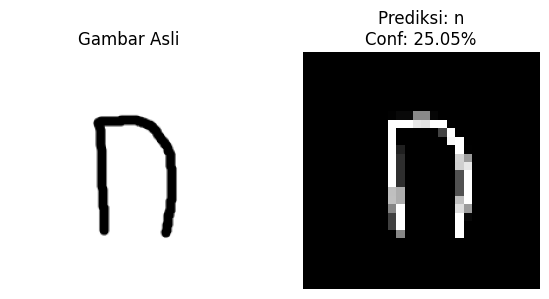

🔎 Prediksi : n
🎯 Asli     : n
📊 Confidence: 25.05%
✅ BENAR

📂 File: O.jpg


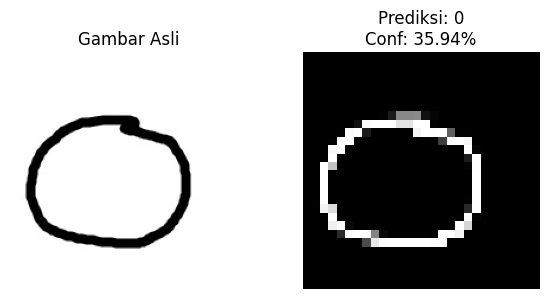

🔎 Prediksi : 0
🎯 Asli     : O
📊 Confidence: 35.94%
❌ SALAH

📂 File: o.png


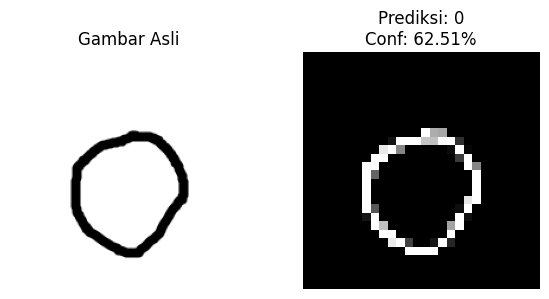

🔎 Prediksi : 0
🎯 Asli     : o
📊 Confidence: 62.51%
❌ SALAH

📂 File: P.jpg


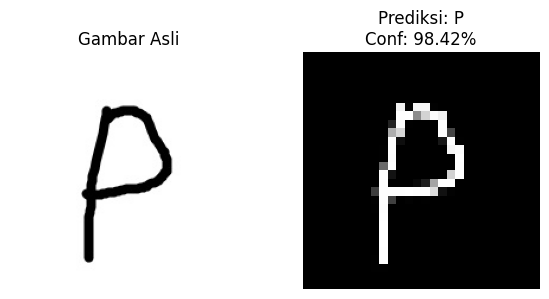

🔎 Prediksi : P
🎯 Asli     : P
📊 Confidence: 98.42%
✅ BENAR

📂 File: p.png


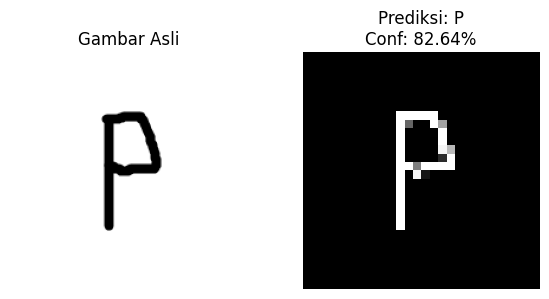

🔎 Prediksi : P
🎯 Asli     : p
📊 Confidence: 82.64%
❌ SALAH

📂 File: Q.jpg


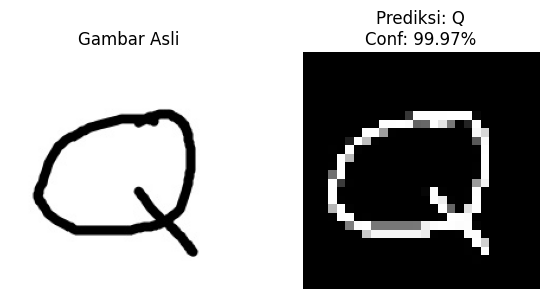

🔎 Prediksi : Q
🎯 Asli     : Q
📊 Confidence: 99.97%
✅ BENAR

📂 File: q.png


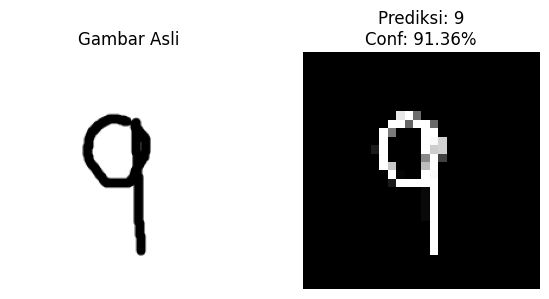

🔎 Prediksi : 9
🎯 Asli     : q
📊 Confidence: 91.36%
❌ SALAH

📂 File: R.jpg


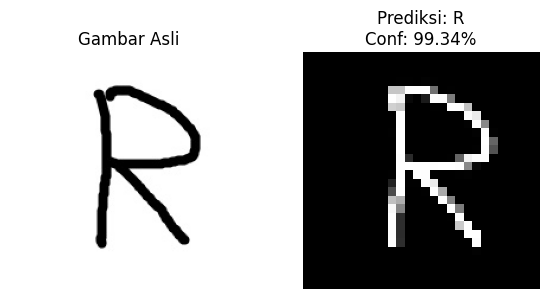

🔎 Prediksi : R
🎯 Asli     : R
📊 Confidence: 99.34%
✅ BENAR

📂 File: r.png


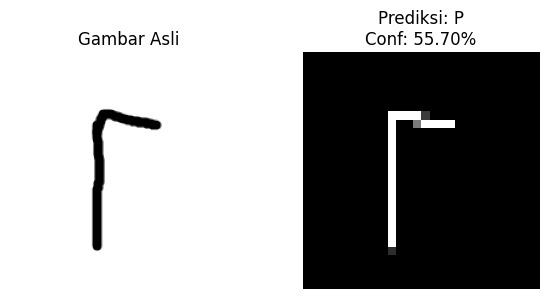

🔎 Prediksi : P
🎯 Asli     : r
📊 Confidence: 55.70%
❌ SALAH

📂 File: S.jpg


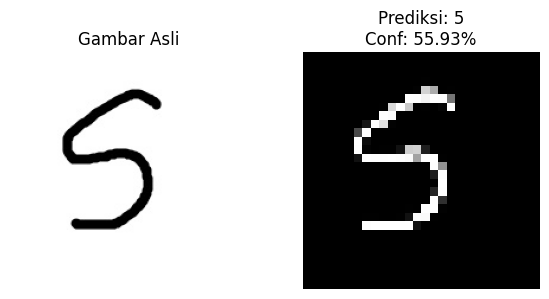

🔎 Prediksi : 5
🎯 Asli     : S
📊 Confidence: 55.93%
❌ SALAH

📂 File: s.png


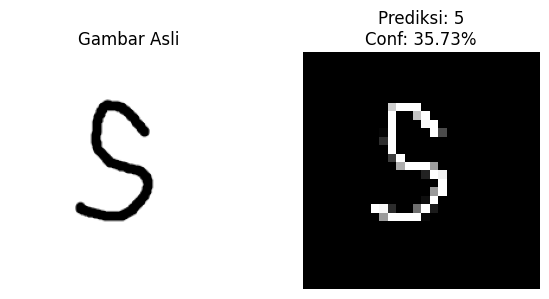

🔎 Prediksi : 5
🎯 Asli     : s
📊 Confidence: 35.73%
❌ SALAH

📂 File: T.jpg


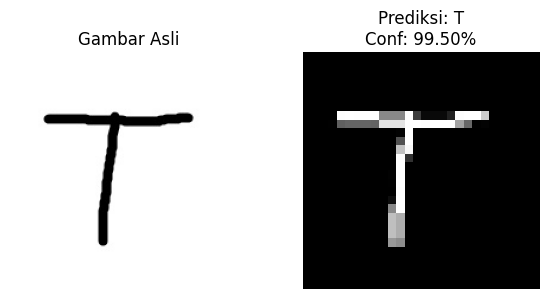

🔎 Prediksi : T
🎯 Asli     : T
📊 Confidence: 99.50%
✅ BENAR

📂 File: t.png


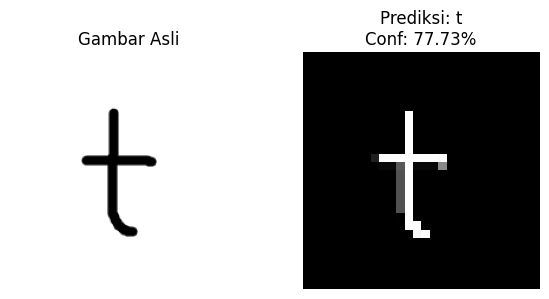

🔎 Prediksi : t
🎯 Asli     : t
📊 Confidence: 77.73%
✅ BENAR

📂 File: U.jpg


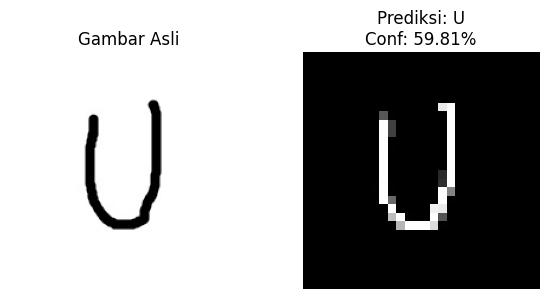

🔎 Prediksi : U
🎯 Asli     : U
📊 Confidence: 59.81%
✅ BENAR

📂 File: u.png


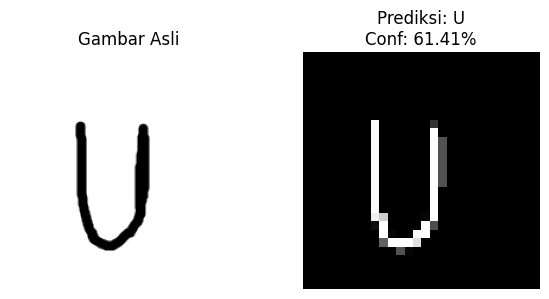

🔎 Prediksi : U
🎯 Asli     : u
📊 Confidence: 61.41%
❌ SALAH

📂 File: V.jpg


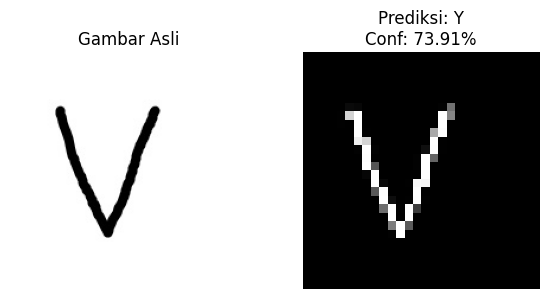

🔎 Prediksi : Y
🎯 Asli     : V
📊 Confidence: 73.91%
❌ SALAH

📂 File: v.png


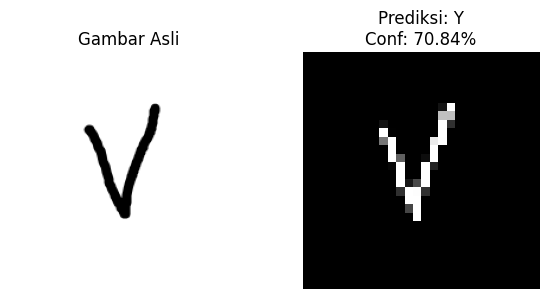

🔎 Prediksi : Y
🎯 Asli     : v
📊 Confidence: 70.84%
❌ SALAH

📂 File: W.jpg


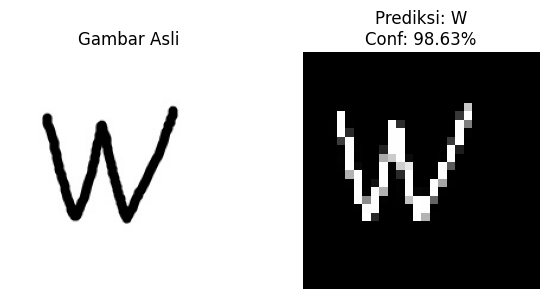

🔎 Prediksi : W
🎯 Asli     : W
📊 Confidence: 98.63%
✅ BENAR

📂 File: w.png


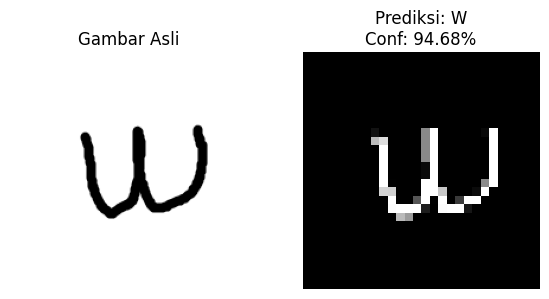

🔎 Prediksi : W
🎯 Asli     : w
📊 Confidence: 94.68%
❌ SALAH

📂 File: X.jpg


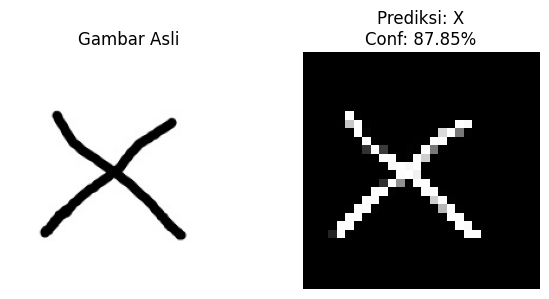

🔎 Prediksi : X
🎯 Asli     : X
📊 Confidence: 87.85%
✅ BENAR

📂 File: x.png


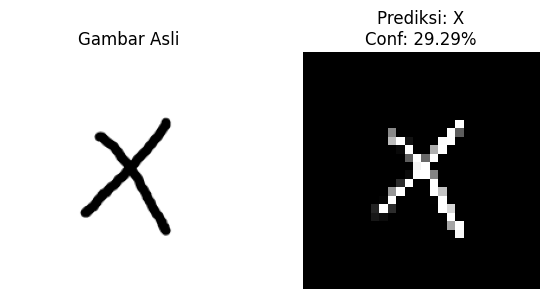

🔎 Prediksi : X
🎯 Asli     : x
📊 Confidence: 29.29%
❌ SALAH

📂 File: Y.jpg


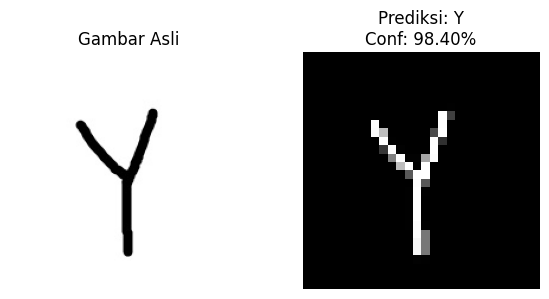

🔎 Prediksi : Y
🎯 Asli     : Y
📊 Confidence: 98.40%
✅ BENAR

📂 File: y.png


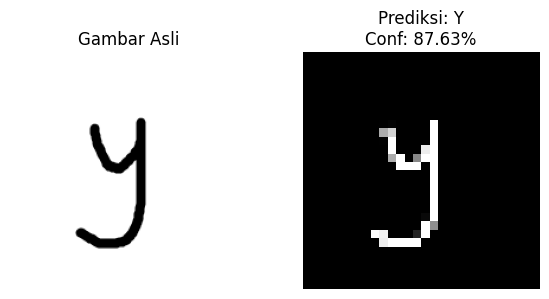

🔎 Prediksi : Y
🎯 Asli     : y
📊 Confidence: 87.63%
❌ SALAH

📂 File: Z.jpg


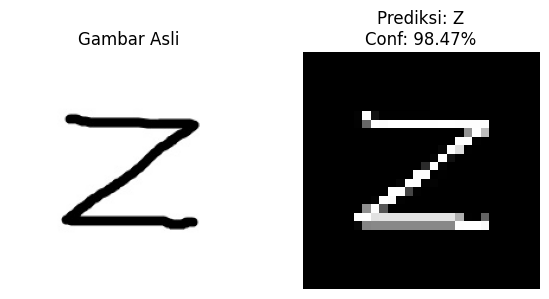

🔎 Prediksi : Z
🎯 Asli     : Z
📊 Confidence: 98.47%
✅ BENAR

📂 File: z.png


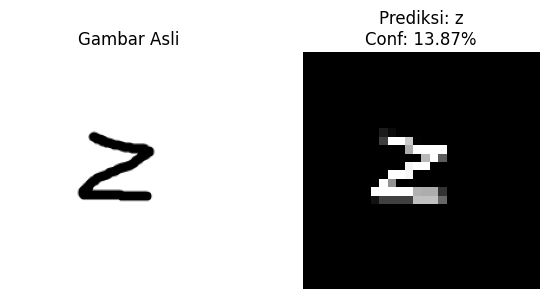

🔎 Prediksi : z
🎯 Asli     : z
📊 Confidence: 13.87%
✅ BENAR

TOTAL DATA : 62
PREDIKSI BENAR : 36
AKURASI : 58.06%


In [5]:
import os

folder_path = r'C:\Users\LENOVO\tubesAILab\emnistTest'

correct = 0
total = 0

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)

        # Label asli dari nama file (tanpa ekstensi)
        true_label = os.path.splitext(filename)[0]

        print(f"\n📂 File: {filename}")
        predicted_char, confidence = predict_handwriting(image_path)

        if predicted_char is None:
            continue

        print(f"🔎 Prediksi : {predicted_char}")
        print(f"🎯 Asli     : {true_label}")
        print(f"📊 Confidence: {confidence*100:.2f}%")

        if predicted_char == true_label:
            print("✅ BENAR")
            correct += 1
        else:
            print("❌ SALAH")

        total += 1

# ================== AKURASI ==================
if total > 0:
    accuracy = correct / total * 100
    print(f"\n==============================")
    print(f"TOTAL DATA : {total}")
    print(f"PREDIKSI BENAR : {correct}")
    print(f"AKURASI : {accuracy:.2f}%")


Pada uji coba data EMNIST diatas harusnya lebih akurasi, dikarenakan 'c' dianggap 'C' beberapa huruf kecil (lowercase) yang sama dengan huruf kapital (uppercase) dianggap saya contohnya c kecil dan C kapital, o kecil dan O kapital, dan yang lainya 

In [24]:
image_path = r'C:\Users\LENOVO\tubesAILab\mathSymbolsTest\3.jpg'
print("Path:", image_path)
print("File exists?", os.path.exists(image_path))


Path: C:\Users\LENOVO\tubesAILab\mathSymbolsTest\3.jpg
File exists? True
